In [2]:
!pip install -U transformers datasets jiwer accelerate librosa --quiet

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from huggingface_hub import login
login()

## __1.데이터셋 로드__

In [4]:
from datasets import load_dataset, Dataset
from itertools import islice

# 각 언어별 streaming 데이터셋 로드
ko_stream = load_dataset("mozilla-foundation/common_voice_13_0", "ko", split="train", streaming=True)
en_stream = load_dataset("mozilla-foundation/common_voice_13_0", "en", split="train", streaming=True)
ja_stream = load_dataset("mozilla-foundation/common_voice_13_0", "ja", split="train", streaming=True)
de_stream = load_dataset("mozilla-foundation/common_voice_13_0", "de", split="train", streaming=True)

# 각각 200개씩 샘플링
ko_samples = list(islice(ko_stream, 100))
en_samples = list(islice(en_stream, 100))
ja_samples = list(islice(ja_stream, 100))
de_samples = list(islice(de_stream, 100))

# 병합하여 하나의 통합 데이터셋 생성
all_samples = ko_samples + en_samples + ja_samples + de_samples
dataset = Dataset.from_list(all_samples)


Reading metadata...: 192it [00:00, 332.26it/s]
Reading metadata...: 1013968it [00:22, 44840.68it/s]
Reading metadata...: 7071it [00:00, 18006.05it/s]
Reading metadata...: 540437it [00:12, 43939.20it/s]


## __2.Whisper-small 불러오기__

In [5]:
from transformers import WhisperProcessor, WhisperFeatureExtractor, WhisperTokenizer, WhisperForConditionalGeneration

# base checkpoint (처음 학습하는 모델)
checkpoint = "openai/whisper-small"

# processor 구성 (언어 고정 없이 다국어 자유롭게 처리)
processor = WhisperProcessor.from_pretrained(checkpoint, language=None, task="transcribe")
feature_extractor = processor.feature_extractor
tokenizer = processor.tokenizer

# 모델 불러오기 + forced_decoder_ids 제거
model = WhisperForConditionalGeneration.from_pretrained(checkpoint)
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

## __3.전처리__

In [6]:
def prepare_dataset(example):
    # 오디오 전처리
    audio = example["audio"]
    example["input_features"] = feature_extractor(audio["array"], sampling_rate=16000).input_features[0]

    # 텍스트 → 레이블 토큰화
    example["labels"] = tokenizer(example["sentence"]).input_ids
    return example

# 전처리 적용
processed_dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [7]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 오디오 입력
        input_features = [{"input_features": f["input_features"]} for f in features]
        # 라벨 입력
        label_features = [{"input_ids": f["labels"]} for f in features]

        # padding 적용
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # label의 padding 위치에 -100을 채워서 loss에 반영되지 않도록
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [8]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/WhisperCheckpoints/run_multi_small_trial1",
    per_device_train_batch_size=4,
    learning_rate=1e-5,
    num_train_epochs=3,
    logging_steps=5,
    save_strategy="epoch",
    fp16=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset,
    tokenizer=processor,
    data_collator=data_collator
)


<ipython-input-8-8934ba60a66a>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## __4.Train__

In [9]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
5,6.509500
10,4.953000
15,4.419100
20,3.795100
25,3.190000
30,2.968600
35,2.626900
40,2.319200
45,1.857300
50,2.083900


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=300, training_loss=1.1802657337983449, metrics={'train_runtime': 380.5339, 'train_samples_per_second': 3.153, 'train_steps_per_second': 0.788, 'total_flos': 3.46302480384e+17, 'train_loss': 1.1802657337983449, 'epoch': 3.0})

In [10]:
# 저장 경로는 학습할 때 썼던 trial 이름과 동일
save_path = "/content/drive/MyDrive/WhisperCheckpoints/run_multi_small_trial1"

model.save_pretrained(save_path)
processor.save_pretrained(save_path)

[]

## __6.Prediction__

In [11]:
import torch
from jiwer import wer
from tqdm import tqdm

# 언어 태그별로 필터링 함수 정의
def filter_by_lang(dataset, lang_code):
    return [x for x in dataset if x["locale"] == lang_code]

# 평가 대상 언어 리스트
lang_list = ["ko", "en", "ja", "de"]

# 전체 결과 저장
lang_wer_results = {}

# 각 언어별 평가
for lang in lang_list:
    print(f"\n🌍 언어: {lang}")
    lang_data = filter_by_lang(dataset, lang)

    predictions = []
    references = []

    for sample in tqdm(lang_data):
        input_features = processor.feature_extractor(
            sample["audio"]["array"], sampling_rate=16000, return_tensors="pt"
        ).input_features.to(model.device)

        with torch.no_grad():
            predicted_ids = model.generate(input_features)

        transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]

        predictions.append(transcription)
        references.append(sample["sentence"])

        # 예측 vs 정답 출력
        print(f"\n🔹 예측: {transcription}")
        print(f"🔸 정답: {sample['sentence']}")

        torch.cuda.empty_cache()

    # WER 계산 및 출력
    score = wer(references, predictions)
    lang_wer_results[lang] = score
    print(f"\n✅ {lang.upper()} WER: {score:.4f}")



🌍 언어: ko


  0%|          | 0/100 [00:00<?, ?it/s]Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
  1%|          | 1/100 [00:02<03:37,  2.20s/it]


🔹 예측: 어느덧 그 더운 발월도 하루를 넘기고 다 지나 버렸다.
🔸 정답: 어느덧 그 더운 팔월도 하루를 남기고 다 지나 버렸다.


  2%|▏         | 2/100 [00:02<02:03,  1.26s/it]


🔹 예측: 근자의 춘우의 동료 사이에는 이상한 소문이 돌아다니었다.
🔸 정답: 근자에 춘우의 동료 사이에는 이상한 소문이 돌아다니었다.


  3%|▎         | 3/100 [00:03<01:29,  1.09it/s]


🔹 예측: 재차 부르는 소리를 듣고야 선비는 발길을 떼었다.
🔸 정답: 재차 부르는 소리를 듣고야 선비는 발길을 떼었다.


  4%|▍         | 4/100 [00:03<01:10,  1.36it/s]


🔹 예측: 그의 말값으로 찾아나 봤으면 되는 것 아니냐.
🔸 정답: 그애의 말값으로 찾아나 봤으면 되는 것 아니냐.


  5%|▌         | 5/100 [00:04<01:04,  1.48it/s]


🔹 예측: 그가 방으로 들어오니 간난이가 와서 그의 하던 일을 하고 있었다.
🔸 정답: 그가 방으로 들어오니 간난이가 와서 그의 하던 일을 하고 있었다.


  6%|▌         | 6/100 [00:04<00:53,  1.75it/s]


🔹 예측: 안녕히 다녀옵시요.
🔸 정답: 안녕히 다녀옵시요.


  7%|▋         | 7/100 [00:05<00:55,  1.68it/s]


🔹 예측: 어떻게 무엇부터 시작을 해야 할는지 엄두가 나지를 않아서 잠을 잘 수가 없었다.
🔸 정답: 어떻게 무엇부터 시작을 해야 할는지 엄두가 나지를 않아서 잠을 잘 수가 없었다.


  8%|▊         | 8/100 [00:05<00:48,  1.90it/s]


🔹 예측: 춘경살까지 하늘을 우러러
🔸 정답: 죽는 날까지 하늘을 우러러


  9%|▉         | 9/100 [00:06<00:45,  1.98it/s]


🔹 예측: 그리고 그 어두운 방안이 휙 지나친다.
🔸 정답: 그리고 그 어두운 방 안이 휙 지나친다.


 10%|█         | 10/100 [00:06<00:41,  2.15it/s]


🔹 예측: 왜 눈을 바루 뜨지 못해
🔸 정답: 왜 눈을 바루 뜨지 못해!


 11%|█         | 11/100 [00:07<00:45,  1.94it/s]


🔹 예측: 영신은 바라던 대로 바닷가 한가한 집에서 여전히 쉴 수가 있었다.
🔸 정답: 영신은 바라던 대로 바닷가 한가한 집에서 편안히 쉴 수가 있었다.


 12%|█▏        | 12/100 [00:07<00:43,  2.01it/s]


🔹 예측: 잡을 수 없는 저 하늘의 별도 잡자.
🔸 정답: 잡을 수 없는 저 하늘의 별도 잡자.


 13%|█▎        | 13/100 [00:08<00:42,  2.07it/s]


🔹 예측: 하고, 울메인 소리가 티를 따랐다.
🔸 정답: 하고, 목메인 소리가 뒤를 따랐다.


 14%|█▍        | 14/100 [00:08<00:42,  2.01it/s]


🔹 예측: 그리고 그의 하던 말을 곰곰이 되풀이하였다.
🔸 정답: 그리고 그의 하던 말을 곰곰이 되풀이하였다.


 15%|█▌        | 15/100 [00:08<00:38,  2.23it/s]


🔹 예측: 영원한 것이 어디 있는가?
🔸 정답: 영원한 것이 어디 있는가?


 16%|█▌        | 16/100 [00:09<00:42,  1.99it/s]


🔹 예측: 그것은 예수가 십자가에 못 박히며 최후로 부르짖은 말이었다.
🔸 정답: 그것은 예수가 십자가에 못박히며 최후로 부르짖은 말이었다.


 17%|█▋        | 17/100 [00:10<00:43,  1.90it/s]


🔹 예측: 그 뚫며 그 침짝은 딴놈이 메고 달아난다.
🔸 정답: 그 틈에 그 짐짝은 딴놈이 메고 달아난다.


 18%|█▊        | 18/100 [00:10<00:46,  1.75it/s]


🔹 예측: 그는 이러한 생각을 되풀이하는 새 벌써 간난네 집까지 왔다.
🔸 정답: 그는 이러한 생각을 되풀이하는 새 벌써 간난네 집까지 왔다.


 19%|█▉        | 19/100 [00:11<00:57,  1.40it/s]


🔹 예측: 여식 떨어진 사람이 보릿고개를 넘기는 것만치 나 까마어득한 것 같습니다.
🔸 정답: 양식 떨어진 사람이 보릿고개를 넘기는것만치 나 까마아득한 것 같습니다.


 20%|██        | 20/100 [00:12<00:54,  1.48it/s]


🔹 예측: 그래서 그는 억지로 웃어 보이고 말았다.
🔸 정답: 그래서 그는 억지로 웃어 보이고 말았다.


 21%|██        | 21/100 [00:13<00:54,  1.44it/s]


🔹 예측: 연예 꾸짖으며 집안을 뻔히는 수밖에 없었다.
🔸 정답: 연해 꾸짖으며 질팡갈팡 뛰는 수밖에 없었다.


 22%|██▏       | 22/100 [00:13<00:50,  1.54it/s]


🔹 예측: 영신을 눕히고 자세히 진찰을 해본다.
🔸 정답: 영신을 눕히고 자세히 진찰을 해본다.


 23%|██▎       | 23/100 [00:14<00:44,  1.75it/s]


🔹 예측: 몇 시 퇴근하려고?
🔸 정답: 몇 시 퇴근하려고?


 24%|██▍       | 24/100 [00:14<00:43,  1.73it/s]


🔹 예측: 국회는 의원의 자격을 심사하며, 의원을 징계할 수 있다.
🔸 정답: 국회는 의원의 자격을 심사하며, 의원을 징계할 수 있다.


 25%|██▌       | 25/100 [00:15<00:45,  1.66it/s]


🔹 예측: 아담의 모든 육축과 공중의 새와 둘이 모든 진실의 이름을 주니라
🔸 정답: 아담이 모든 육축과 공중의 새와 들의 모든 짐승에게 이름을 주니라


 26%|██▌       | 26/100 [00:16<00:45,  1.64it/s]


🔹 예측: 그 뒤로 개닭질 같은 집들이 오글오글 쫓겨서 몰려들어간다.
🔸 정답: 그 뒤로 게 딱지 같은 집들이 오글오글 쫓겨서 몰려들어 간다.


 27%|██▋       | 27/100 [00:16<00:45,  1.59it/s]


🔹 예측: 그리고 그의 옷이 땀에 배어 어룽어룽하니 말라진 것을 보았다.
🔸 정답: 그리고 그의 옷이 땀에 배어 어룽어룽하니 말라진 것을 보았다.


 28%|██▊       | 28/100 [00:17<00:42,  1.70it/s]


🔹 예측: 춘우는 자기 아버지가 약주 취하신 것을 알았다.
🔸 정답: 춘우는 자기 아버지가 약주 취하신 것을 알았다.


 29%|██▉       | 29/100 [00:17<00:41,  1.73it/s]


🔹 예측: 찌르릉 하고 창자에 퍼지며 얼굴이 확 끊어야 했다.
🔸 정답: 찌르릉 하고 창자에 퍼지며 얼굴이 화끈하였다.


 30%|███       | 30/100 [00:18<00:41,  1.67it/s]


🔹 예측: 바람은 파도 소리처럼 쏴아쏴아 하고 머리 맞혀서 뒤설렌다.
🔸 정답: 바람은 파도 소리처럼 쏴아쏴아 하고 머리 맡에서 뒤설렌다.


 31%|███       | 31/100 [00:18<00:38,  1.80it/s]


🔹 예측: 춘우에게 이 모든 사정의 말을 하여 버릴까.
🔸 정답: 춘우에게 이 모든 사정의 말을 하여 버릴까.


 32%|███▏      | 32/100 [00:19<00:38,  1.79it/s]


🔹 예측: 그가는 사람이 걱정을 하리만큼 그의 걸음은 황급하였다.
🔸 정답: 길 가는 사람이 걱정을 하리만큼 그의 걸음은 황급하였다.


 33%|███▎      | 33/100 [00:20<00:41,  1.61it/s]


🔹 예측: 선비는 간난이가 저렇게 늦게 돌아올 때마다 무엇을 깊이 생각하는 것이 수상스러웠다.
🔸 정답: 선비는 간난이가 저렇게 늦게 돌아올 때마다 무엇을 깊이 생각하는 것이 수상스러웠다.


 34%|███▍      | 34/100 [00:20<00:35,  1.87it/s]


🔹 예측: Borona is a beautiful city.
🔸 정답: 부엌은 아름답게 장식되었습니다.


 35%|███▌      | 35/100 [00:21<00:34,  1.86it/s]


🔹 예측: 신철이는 할멈이 깨어 숨으로 그만 남검을 하였다.
🔸 정답: 신철이는 할멈이 깨었으므로 그만 낙망을 하였다.


 36%|███▌      | 36/100 [00:21<00:34,  1.84it/s]


🔹 예측: 납작한 얼굴을 쳐들고 첫째의 눈치를 살살 본다.
🔸 정답: 납작한 얼굴을 쳐들고 첫째의 눈치를 살살 본다.


 37%|███▋      | 37/100 [00:22<00:37,  1.69it/s]


🔹 예측: 아담과 그 아내가 여호와 하나님의 나칠 피아녀 동산 나무 사이에 숨은지라
🔸 정답: 아담과 그 아내가 여호와 하나님의 낯을 피하여 동산 나무 사이에 숨은지라


 38%|███▊      | 38/100 [00:22<00:32,  1.92it/s]


🔹 예측: 나는 두 번째 그에게 물었습니다.
🔸 정답: 나는 두 번째 그에게 물었습니다.


 39%|███▉      | 39/100 [00:23<00:29,  2.08it/s]


🔹 예측: 무소식이 무소식이다
🔸 정답: 무소식이 희소식이다


 40%|████      | 40/100 [00:23<00:29,  2.05it/s]


🔹 예측: 그는 대답 대신에 늘 이렇게 웃는 것이 버릇이다.
🔸 정답: 그는 대답 대신에 늘 이렇게 웃는 것이 버릇이다.


 41%|████      | 41/100 [00:24<00:34,  1.69it/s]


🔹 예측: 대저 너희가 지식을 미워하며 여호와 경외하기를 즐거워하지 아니하며
🔸 정답: 대저 너희가 지식을 미워하며 여호와 경외하기를 즐거워하지 아니하며


 42%|████▏     | 42/100 [00:24<00:30,  1.89it/s]


🔹 예측: 경기 시작됐습니다.
🔸 정답: 경기 시작됐습니다.


 43%|████▎     | 43/100 [00:25<00:37,  1.52it/s]


🔹 예측: 선비는 육백삼호인 가마 곁으로 와서 동무의 어깨를 뱉게 쳤다.
🔸 정답: 선비는 육백삼호인 가마 곁으로 와서 동무의 어깨를 가볍게 쳤다.


 44%|████▍     | 44/100 [00:26<00:40,  1.39it/s]


🔹 예측: 그래서 간난 어머니는 눈을 둥그렇게 뜨고 눈치를 살폈다.
🔸 정답: 그래서 간난 어머니는 눈을 둥그렇게 뜨고 눈치를 살폈다.


 45%|████▌     | 45/100 [00:27<00:37,  1.47it/s]


🔹 예측: 그러자 엉엉 하고 오는 개똥이의 곡성을 들은 듯 싶다.
🔸 정답: 그러자 엉엉 하고 우는 개똥이의 곡성을 들은 듯싶다.


 46%|████▌     | 46/100 [00:27<00:36,  1.48it/s]


🔹 예측: 그러나 무엇이라고 꼭 집어대어 철수와 같이 술술 지껄일 수는 없었다.
🔸 정답: 그러나 무엇이라고 꼭 집어대어 철수와 같이 술술 지껄일수는 없었다.


 47%|████▋     | 47/100 [00:28<00:37,  1.43it/s]


🔹 예측: 고난의 시기에 동의하지 않는 것은 진정, 진정 바람만 함께하는 일부러 징궐이다.
🔸 정답: 고난의 시기에 동요하지 않는 것은 진정 칭찬받을 만한 뛰어난 인물의 증거다.


 48%|████▊     | 48/100 [00:29<00:34,  1.51it/s]


🔹 예측: 영신은 다시 부르짖듯이 신앙의 대상자에게 우수한다.
🔸 정답: 영신은 다시 부르짖듯이 신앙의 대상자에게 호소한다.


 49%|████▉     | 49/100 [00:29<00:34,  1.50it/s]


🔹 예측: 그리고 선비의 그 고운 얼굴이 미소를 띠고 지나치는 것을 그는 확실히 보았다.
🔸 정답: 그리고 선비의 그 고운 얼굴이 미소를 띠고 지나치는 것을 그는 확실히 보았다.


 50%|█████     | 50/100 [00:30<00:32,  1.55it/s]


🔹 예측: 나의 교훈을 받지 아니하고 나의 모든 천망을 없인여갔음이라
🔸 정답: 나의 교훈을 받지 아니하고 나의 모든 책망을 업신여겼음이라


 51%|█████     | 51/100 [00:30<00:26,  1.82it/s]


🔹 예측: 개천에서 욕난다.
🔸 정답: 개천에서 용 난다


 52%|█████▏    | 52/100 [00:31<00:28,  1.70it/s]


🔹 예측: 나는 그 알레그로가 울리어 나오는 순간 마음은 끝까지 긴장되고 흥분되었습니다.
🔸 정답: 나는 그 알레그로가 울리어 나오는 순간 마음은 끝까지 긴장되고 흥분되었습니다.


 53%|█████▎    | 53/100 [00:32<00:27,  1.73it/s]


🔹 예측: 선비가 이 공장에 들어온 지가 벌써 거의 일년이 되어 온다.
🔸 정답: 선비가 이 공장에 들어온 지가 벌써 거의 일년이 되어 온다.


 54%|█████▍    | 54/100 [00:32<00:27,  1.70it/s]


🔹 예측: 벌써부터 이런 생각을 가졌으나 용이하게 기회를 타는 수가 없었다.
🔸 정답: 벌써부터 이런 생각을 가졌으나 용이하게 기회를 타는 수가 없었다.


 55%|█████▌    | 55/100 [00:33<00:27,  1.66it/s]


🔹 예측: 그는 종잇조각과 연필을 내어 신철에게 무엇을 써서 보였다.
🔸 정답: 그는 종잇조각과 연필을 내어 신철에게 무엇을 써서 보였다.


 56%|█████▌    | 56/100 [00:33<00:27,  1.62it/s]


🔹 예측: 헌법재판소 재판관은 정당에 가입하거나 정치에 관여할 수 없다.
🔸 정답: 헌법재판소 재판관은 정당에 가입하거나 정치에 관여할 수 없다.


 57%|█████▋    | 57/100 [00:34<00:25,  1.66it/s]


🔹 예측: 이번엔 제법 목소리가 패인 남학생의 질문이 들어왔다.
🔸 정답: 이번엔 제법 목소리가 패인 남학생의 질문이 들어왔다.


 58%|█████▊    | 58/100 [00:35<00:24,  1.70it/s]


🔹 예측: 한번의 실패와 영원한 실패를 혼동하지 마라.
🔸 정답: 한번의 실패와 영원한 실패를 혼동하지 마라.


 59%|█████▉    | 59/100 [00:35<00:23,  1.73it/s]


🔹 예측: 방망이 소리는 그가 걸을수록 점점 희미하게 들렸다.
🔸 정답: 방망이 소리는 그가 걸을수록 점점 희미하게 들렸다.


 60%|██████    | 60/100 [00:36<00:22,  1.79it/s]


🔹 예측: 모든 국민은 학문과 예술의 자유를 가진다.
🔸 정답: 모든 국민은 학문과 예술의 자유를 가진다.


 61%|██████    | 61/100 [00:37<00:25,  1.50it/s]


🔹 예측: 학생 또는 보호자는 학생 본인에 관한 학교 기록을 언제든지 영함할 권리를 가진다.
🔸 정답: 학생 또는 보호자는 학생 본인에 관한 학교 기록을 언제든지 열람할 권리를 가진다.


 62%|██████▏   | 62/100 [00:37<00:23,  1.63it/s]


🔹 예측: 그는 방 밑에 착 붙어서 떳다.
🔸 정답: 그는 담 밑에 착 붙어 섰다.


 63%|██████▎   | 63/100 [00:38<00:21,  1.70it/s]


🔹 예측: 사랑은 말이지, 소유하는 게 아니야.
🔸 정답: 사랑은 말이지, 소유하는 게 아니야.


 64%|██████▍   | 64/100 [00:38<00:21,  1.65it/s]


🔹 예측: 효애는 여전히 뭐라고 소곤소곤 이야기를 하였다.
🔸 정답: 효애는 여전히 뭐라고 소곤소곤 이야기를 하였다.


 65%|██████▌   | 65/100 [00:39<00:21,  1.62it/s]


🔹 예측: 점심 뒤에 회원들은 잡담을 하며 잠시 쉬었다.
🔸 정답: 점심 뒤에 회원들은 잡담을 하며 잠시 쉬었다.


 66%|██████▌   | 66/100 [00:40<00:22,  1.50it/s]


🔹 예측: 영신은 그제야 그전에 백 씨의 집에서 들은 동혁의 말을 되풀이하듯 하였다.
🔸 정답: 영신은 그제야 그전에 백씨의 집에서 들은 동혁의 말을 되풀이하듯 하였다.


 67%|██████▋   | 67/100 [00:40<00:19,  1.67it/s]


🔹 예측: 세상에 나의 마음을 알아 주는 사람이 어디 있어야죠.
🔸 정답: 세상에 나의 마음을 알아 주는 사람이 어디 있어야죠.


 68%|██████▊   | 68/100 [00:41<00:17,  1.80it/s]


🔹 예측: 부르짖으며 저 혼자 감격하는 것이었다.
🔸 정답: 부르짖으며 저 혼자 감격하는 것이었다.


 69%|██████▉   | 69/100 [00:41<00:19,  1.57it/s]


🔹 예측: 두 아들은 방 속에다 죽은 그 아버지의 송장을 제쳐놓고 서로 잡아삼킬 듯이 다투고 있었습니다.
🔸 정답: 두 아들은 방 속에다 죽은 그 아버지의 송장을 제쳐놓고 서로 잡아삼킬 듯이 다투고 있었습니다.


 70%|███████   | 70/100 [00:42<00:18,  1.60it/s]


🔹 예측: 여자가 뱀에게 말하되 동산 나무의 실과를 우리가 먹을 수 있으나
🔸 정답: 여자가 뱀에게 말하되 동산 나무의 실과를 우리가 먹을 수 있으나


 71%|███████   | 71/100 [00:42<00:16,  1.76it/s]


🔹 예측: 국가는 국가표준제도를 확립한다.
🔸 정답: 국가는 국가표준제도를 확립한다.


 72%|███████▏  | 72/100 [00:43<00:15,  1.77it/s]


🔹 예측: 다른 누구에게도 의지하지 말고 오직 그대 혼자의 힘으로 하라.
🔸 정답: 다른 누구에게도 의지하지 말고 오직 그대 혼자의 힘으로 하라.


 73%|███████▎  | 73/100 [00:43<00:14,  1.81it/s]


🔹 예측: 까불이는 의자를 버쩍 들어 옮겨 놔주었다.
🔸 정답: 까불이는 의자를 버쩍 들어 옮겨 놔주었다.


 74%|███████▍  | 74/100 [00:44<00:13,  1.94it/s]


🔹 예측: 그가 좋아할 때마다 이런 버릇이 있었다.
🔸 정답: 그가 좋아할 때마다 이런 버릇이 있었다.


 75%|███████▌  | 75/100 [00:44<00:12,  1.95it/s]


🔹 예측: 탄핵결정은 공직으로부터 파멸함에 그친다.
🔸 정답: 탄핵결정은 공직으로부터 파면함에 그친다.


 76%|███████▌  | 76/100 [00:45<00:13,  1.79it/s]


🔹 예측: 한편으로 그가 영신을 될 수 있는 대로 호의로써 이하려는 것도 물론이다.
🔸 정답: 한편으로 그가 영신을 될 수 있는 대로 호의로써 이해하려는 것도 물론이다.


 77%|███████▋  | 77/100 [00:46<00:13,  1.67it/s]


🔹 예측: 선비는 얼굴이 뻘이 돼서 가마에서 뽑혀 나오는 실 끝을 들여 놔보았다.
🔸 정답: 선비는 얼굴이 뻘개서 가마에서 뽑혀 나오는 실끝을 들여다보았다.


 78%|███████▊  | 78/100 [00:46<00:13,  1.67it/s]


🔹 예측: 무척 배가 고팠음에도 당분간은 아무것도 먹지 않기로 했다.
🔸 정답: 무척 배가 고팠음에도 당분간은 아무것도 먹지 않기로 했다.


 79%|███████▉  | 79/100 [00:47<00:12,  1.67it/s]


🔹 예측: 신철이는 영철의 우는 소리를 들으며 문밖을 나섰다.
🔸 정답: 신철이는 영철의 우는 소리를 들으며 문밖을 나섰다.


 80%|████████  | 80/100 [00:48<00:12,  1.63it/s]


🔹 예측:  혹은 사오십 년 뒤에 조선을 무대로 생겨날 이야기라고 생각하여도 좋다.
🔸 정답: 혹은 사오십 년 뒤에 조선을 무대로 생겨날 이야기라고 생각하여도 좋다.


 81%|████████  | 81/100 [00:48<00:09,  1.93it/s]


🔹 예측: 어디서 오셨어요?
🔸 정답: 어디서 오셨어요?


 82%|████████▏ | 82/100 [00:48<00:09,  1.90it/s]


🔹 예측: 덕호는 문 안에 선 채 선비 어머니를 바라보며 걱정을 한다.
🔸 정답: 덕호는 문 안에 선 채 선비 어머니를 바라보며 걱정을 한다.


 83%|████████▎ | 83/100 [00:49<00:09,  1.76it/s]


🔹 예측: 그리고 무어라고 손질을 두어 번 치고 몸이 밭뒤로 사라진다.
🔸 정답: 그리고 무어라고 손질을 두어 번 치고 모밀 밭뒤로 사라진다.


 84%|████████▍ | 84/100 [00:50<00:10,  1.56it/s]


🔹 예측: 선비는 시야 들도 만지지 않으면 앞이 허전한 것 같아서 그냥 붙들고 있었다.
🔸 정답: 선비는 씨아틀도 만지지 않으면 앞이 허전한 것 같아서 그냥 붙들고 있었다.


 85%|████████▌ | 85/100 [00:51<00:10,  1.42it/s]


🔹 예측: 동시에 잠깐 잊었던 아픔이 그의 전신을 못 견디게 습격하였다.
🔸 정답: 동시에 잠깐 잊었던 아픔이 그의 전신을 못 견디게 습격하였다.


 86%|████████▌ | 86/100 [00:52<00:11,  1.24it/s]


🔹 예측: 첫째는 무정처하고 걷다가 다시 덕호의 집 주위를 한 바퀴 돌아서 그의 집으로 왔다.
🔸 정답: 첫째는 무정처하고 걷다가 다시 덕호의 집 주위를 한 바퀴 돌아서 그의 집으로 왔다.


 87%|████████▋ | 87/100 [00:52<00:09,  1.34it/s]


🔹 예측: 사회 교화자로서의 의견을 말씀해주십쇼."
🔸 정답: 사회 교화자로서의 의견을 말씀해주십쇼."


 88%|████████▊ | 88/100 [00:53<00:08,  1.50it/s]


🔹 예측: 그는 마침내 그 엎지를 욱 하고 하였다.
🔸 정답: 그는 마침내 구역질을 욱 하고 하였다.


 89%|████████▉ | 89/100 [00:54<00:07,  1.53it/s]


🔹 예측: 장호와 다른 교인들이 들어와 병원으로 가기를 번차례로 권하였다.
🔸 정답: 장로와 다른 교인들이 들어와 병원으로 가기를 번차례로 권하였다.


 90%|█████████ | 90/100 [00:54<00:06,  1.58it/s]


🔹 예측: 그래서 그는 잘못 찾아왔는가 하여 도로 나와서 주저하다가 다시 들어갔다.
🔸 정답: 그래서 그는 잘못 찾아왔는가 하여 도로 나와서 주저하다가 다시 들어갔다.


 91%|█████████ | 91/100 [00:54<00:04,  1.87it/s]


🔹 예측: 나는 아무 걱정도 없이
🔸 정답: 나는 아무 걱정도 없이


 92%|█████████▏| 92/100 [00:55<00:04,  1.94it/s]


🔹 예측: 평안도 어느 산 깊은 금덤판.
🔸 정답: 평안도 어느 산 깊은 금덤판.


 93%|█████████▎| 93/100 [00:56<00:04,  1.68it/s]


🔹 예측: 비록 고구라 양복의 망정 노박이로 비를 맞으며 김첨지를 뒤쫓아 나왔으랴.
🔸 정답: 비록 고구라 양복일 망정 노박이로 비를 맞으며 김첨지를 뒤쫓아 나왔으랴.


 94%|█████████▍| 94/100 [00:56<00:03,  1.71it/s]


🔹 예측: 팔을 놀리면 팔이 아프고 다리를 놀리면 다리가 아팠다.
🔸 정답: 팔을 놀리면 팔이 아프고 다리를 놀리면 다리가 아팠다.


 95%|█████████▌| 95/100 [00:57<00:02,  1.68it/s]


🔹 예측: 그가 방문을 소리 없이 열고 나서니 옆집에서는 시계가 새로 도시를 친다.
🔸 정답: 그가 방문을 소리 없이 열고 나서니 옆집에서는 시계가 새로 두시를 친다.


 96%|█████████▌| 96/100 [00:57<00:02,  1.75it/s]


🔹 예측: 영숙은 다시 춘우의 마음을 헤아려 보았다.
🔸 정답: 영숙은 다시 춘우의 마음을 헤아려 보았다.


 97%|█████████▋| 97/100 [00:58<00:01,  1.63it/s]


🔹 예측: 본래부터 뼈만 남았던 그가 한층 더하여 마치 해골을 대하는게 되었다.
🔸 정답: 본래부터 뼈만 남았던 그가 한층 더하여 마치 해골을 대하는 듯하였다.


 98%|█████████▊| 98/100 [00:58<00:01,  1.81it/s]


🔹 예측: 그래봐야 아무것도 얻을 것이 없다.
🔸 정답: 그래봐야 아무것도 얻을 것이 없다.


 99%|█████████▉| 99/100 [00:59<00:00,  1.67it/s]


🔹 예측: 고즈넉히 일어서서 피아노 앞에 가서 그의 어깨에 가만히 손을 얹었습니다.
🔸 정답: 고즈넉히 일어서서 피아노 앞에 가서 그의 어깨에 가만히 손을 얹었습니다.


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


🔹 예측: 난장보살은 호미로 땅을 치며 이렇게 소리쳤다.
🔸 정답: 난장보살은 호미로 땅을 치며 이렇게 소리쳤다.

✅ KO WER: 0.1191

🌍 언어: en



  1%|          | 1/100 [00:00<01:14,  1.33it/s]


🔹 예측:  This device has a cathode inside an anode wire cage.
🔸 정답: This device has a cathode inside an anode wire cage.


  2%|▏         | 2/100 [00:01<00:54,  1.81it/s]


🔹 예측:  This product is almost always produced by the industrialized method.
🔸 정답: This product is almost always produced by the industrialized method.


  3%|▎         | 3/100 [00:01<00:46,  2.10it/s]


🔹 예측:  It is named after Edward Singleton Holden.
🔸 정답: It is named after Edward Singleton Holden.


  4%|▍         | 4/100 [00:01<00:42,  2.25it/s]


🔹 예측:  Just north west of the regional centre of Clare.
🔸 정답: It is north west of the regional centre of Clare.


  5%|▌         | 5/100 [00:02<00:43,  2.17it/s]


🔹 예측:  He was a nephew of Rear-Admiral Sir Francis Augustus Collier.
🔸 정답: He was a nephew of Rear-Admiral Sir Francis Augustus Collier.


  6%|▌         | 6/100 [00:02<00:40,  2.33it/s]


🔹 예측: Leaving for some darn camp in Mississippi.
🔸 정답: Leaving for some darn camp in Mississippi.


  7%|▋         | 7/100 [00:03<00:41,  2.26it/s]


🔹 예측:  All employed in this role, Johnson won the prestigious Robert F. Kennedy Award.
🔸 정답: While employed in this role, Johnson won the prestigious Robert F. Kennedy Award.


  8%|▊         | 8/100 [00:03<00:43,  2.14it/s]


🔹 예측:  Samuel Lyons proceeded to subdivide Byrd-Duck Farm into substantial estates.
🔸 정답: Samuel Lyons proceeded to subdivide Five Dock Farm into substantial estates.


  9%|▉         | 9/100 [00:04<00:38,  2.38it/s]


🔹 예측: Where did it come from then?
🔸 정답: Where did it come from then?


 10%|█         | 10/100 [00:04<00:38,  2.36it/s]


🔹 예측:  Since then, three more have been abolished, leaving four.
🔸 정답: Since then, three more have been abolished, leaving four.


 11%|█         | 11/100 [00:05<00:40,  2.21it/s]


🔹 예측:  Now, while drawing the Atlantic Torpedo Fleet, based at Newport, Rhode Island,
🔸 정답: "Narwhal" joined the Atlantic Torpedo Fleet, based at Newport, Rhode Island.


 12%|█▏        | 12/100 [00:05<00:40,  2.16it/s]


🔹 예측:  The airline was later removed from the blacklist after complying with safety audits.
🔸 정답: The airline was later removed from the blacklist after complying with safety audits.


 13%|█▎        | 13/100 [00:06<00:40,  2.14it/s]


🔹 예측:  "The paper has the slogan, 'Never Apologise, Never Explain.'"
🔸 정답: The paper has the slogan "Never Apologise, Never Explain!".


 14%|█▍        | 14/100 [00:06<00:35,  2.39it/s]


🔹 예측: He was born in Tokyo.
🔸 정답: He was born in Tokyo.


 15%|█▌        | 15/100 [00:06<00:32,  2.65it/s]


🔹 예측: You just shoot that.
🔸 정답: You just shoot that.


 16%|█▌        | 16/100 [00:07<00:34,  2.42it/s]


🔹 예측: Chen was a low profile talented scholar with a number of "first" accomplishments.
🔸 정답: Chen was a low profile talented scholar with a number of "first" accomplishments.


 17%|█▋        | 17/100 [00:07<00:36,  2.26it/s]


🔹 예측:  The fulcrum city council asked the county to name the library after Lutts.
🔸 정답: The Fulshear City Council asked the county to name the library after Lutts.


 18%|█▊        | 18/100 [00:08<00:41,  1.97it/s]


🔹 예측: The Cascade Lakes Scenic Byway continues south along the west side of Mount Bachelor.
🔸 정답: The Cascade Lakes Scenic Byway continues south along the west side of Mount Bachelor.


 19%|█▉        | 19/100 [00:08<00:36,  2.23it/s]


🔹 예측:  Montgomery was eliminated.
🔸 정답: Montgomerie was eliminated.


 20%|██        | 20/100 [00:09<00:40,  1.97it/s]


🔹 예측: Depending on the time period and culture, the term can have several meanings.
🔸 정답: Depending on the time period and culture, the term can have several meanings.


 21%|██        | 21/100 [00:09<00:40,  1.95it/s]


🔹 예측:  The objective of the game is to capture your opponent's king.
🔸 정답: The objective of the game is to capture your opponent's king.


 22%|██▏       | 22/100 [00:10<00:39,  1.98it/s]


🔹 예측: It is a producer of photovoltaic solar modules.
🔸 정답: It is a producer of photovoltaic solar modules.


 23%|██▎       | 23/100 [00:10<00:38,  2.02it/s]


🔹 예측: Population change chart of Chendol.
🔸 정답: Population change chart of Chênedouit


 24%|██▍       | 24/100 [00:11<00:34,  2.19it/s]


🔹 예측:  I have to be with my father.
🔸 정답: I have to be with my father.


 25%|██▌       | 25/100 [00:11<00:35,  2.10it/s]


🔹 예측: In the dormitory where Beppe used to work, they joked around almost always.
🔸 정답: In the dormitory where Beppe used to work they joked around almost always.


 26%|██▌       | 26/100 [00:12<00:36,  2.03it/s]


🔹 예측: It was a foremost in nature and did not protest against the temptation of total amazing work.
🔸 정답: It was reformist in nature and did not protest against Sanation authoritarianism or capitalism.


 27%|██▋       | 27/100 [00:12<00:34,  2.13it/s]


🔹 예측:  Madison stated that the current system is "not fit for purpose".
🔸 정답: Morrison stated that the current system is "not fit for purpose".


 28%|██▊       | 28/100 [00:12<00:32,  2.19it/s]


🔹 예측: Criston also served on Berkshire County Council.
🔸 정답: Crichton also served on Berkshire County Council.


 29%|██▉       | 29/100 [00:13<00:31,  2.28it/s]


🔹 예측: The cast included Gianna Rowlands and Diana Lane.
🔸 정답: The cast included Gena Rowlands and Diane Lane.


 30%|███       | 30/100 [00:13<00:30,  2.32it/s]


🔹 예측:  Many of its mineral reserves have yet to be fully tapped.
🔸 정답: Many of its mineral reserves have yet to be fully tapped.


 31%|███       | 31/100 [00:14<00:29,  2.31it/s]


🔹 예측: The Gatineau casino thus also serves Ottawa and Eastern Ontario.
🔸 정답: The Gatineau casino thus also serves Ottawa and Eastern Ontario.


 32%|███▏      | 32/100 [00:14<00:28,  2.37it/s]


🔹 예측: John Strachan and William Allen and moved to Toronto.
🔸 정답: John Strachan and William Allan and moved to Toronto.


 33%|███▎      | 33/100 [00:15<00:29,  2.27it/s]


🔹 예측:  Ringing is the result of overshoot caused by an underdamped circuit.
🔸 정답: Ringing is the result of overshoot caused by an underdamped circuit.


 34%|███▍      | 34/100 [00:15<00:27,  2.36it/s]


🔹 예측: He was the son of Admiral Henry Bielke.
🔸 정답: He was the son of Admiral Henrik Bielke.


 35%|███▌      | 35/100 [00:15<00:27,  2.34it/s]


🔹 예측:  Johannes Sturho was President of the Finnish Chess Federation.
🔸 정답: Johannes Terho was vice president of the Finnish Chess Federation.


 36%|███▌      | 36/100 [00:16<00:26,  2.44it/s]


🔹 예측:  She was also cast in "Wild Guys".
🔸 정답: She was also cast in "Wild Guys".


 37%|███▋      | 37/100 [00:16<00:25,  2.51it/s]


🔹 예측:  Daubas marī ar treikai.
🔸 정답: Douw was married three times.


 38%|███▊      | 38/100 [00:17<00:24,  2.54it/s]


🔹 예측: Gonga's mother is actress Susan Harrison.
🔸 정답: Conger's mother is actress Susan Harrison.


 39%|███▉      | 39/100 [00:17<00:23,  2.57it/s]


🔹 예측: It is a skiing resort with modern skiing equipment.
🔸 정답: It is a skiing resort with modern skiing equipment.


 40%|████      | 40/100 [00:17<00:25,  2.40it/s]


🔹 예측: He then asks Helmut to do his hammering "with a little discretion".
🔸 정답: He then asks Helmut to do his hammering "with a little discretion".


 41%|████      | 41/100 [00:18<00:24,  2.40it/s]


🔹 예측: Jones refused and wrote about the incident on her website.
🔸 정답: Jones refused and wrote about the incident on her website.


 42%|████▏     | 42/100 [00:18<00:24,  2.38it/s]


🔹 예측:  Aruplandis viit varkins palat.
🔸 정답: A ripe plum is fit for a king's palate.


 43%|████▎     | 43/100 [00:19<00:25,  2.28it/s]


🔹 예측:  Couch is known as also local primary school in the Kawakawa region.
🔸 정답: Karetu School is also a local primary school in the Kawakawa region.


 44%|████▍     | 44/100 [00:19<00:23,  2.34it/s]


🔹 예측:  The location is between the towns of Jean and Cren.
🔸 정답: The location is between the towns of Jean and Primm.


 45%|████▌     | 45/100 [00:20<00:23,  2.30it/s]


🔹 예측:  A colony of the Moravian Church was also founded in the same year.
🔸 정답: A colony of the Moravian Church was also founded in the same year.


 46%|████▌     | 46/100 [00:20<00:24,  2.21it/s]


🔹 예측:  During these dates, Fond begins to relate the tale of her friend's parents.
🔸 정답: During these dates, Fang begins to relate the tale of her friend's parents.


 47%|████▋     | 47/100 [00:21<00:25,  2.11it/s]


🔹 예측: He moved to Boston, where he became increasingly obsessed with his health.
🔸 정답: He moved to Boston, where he became increasingly obsessed with his health.


 48%|████▊     | 48/100 [00:21<00:26,  1.95it/s]


🔹 예측: After running the election, Sharon needed to form a government in the Gnesset.
🔸 정답: After winning the election, Sharon needed to form a government in the Knesset.


 49%|████▉     | 49/100 [00:22<00:27,  1.88it/s]


🔹 예측: The film was animated in both Britain and San Francisco, California.
🔸 정답: The film was animated in both Britain and San Francisco, California.


 50%|█████     | 50/100 [00:22<00:23,  2.08it/s]


🔹 예측: His alternative position was wing.
🔸 정답: His alternative position was wing.


 51%|█████     | 51/100 [00:23<00:23,  2.09it/s]


🔹 예측: As a solo performer, he later released two albums.
🔸 정답: As a solo performer, he later released two albums.


 52%|█████▏    | 52/100 [00:23<00:24,  1.97it/s]


🔹 예측: The first annuals widely used, places are sunspots.
🔸 정답: The first and most widely used tracers are sunspots.


 53%|█████▎    | 53/100 [00:24<00:23,  1.99it/s]


🔹 예측: They are going to get penalized for it, but so what?
🔸 정답: They're going to get penalized for it, but So what?


 54%|█████▍    | 54/100 [00:24<00:22,  2.08it/s]


🔹 예측:  The game had changed by the time the first Spanish settlers arrived.
🔸 정답: The game had changed by the time the first Spanish settlers arrived.


 55%|█████▌    | 55/100 [00:25<00:23,  1.89it/s]


🔹 예측:  Some Indian patterned cars saw used in the Indian subcontinent in Bombay.
🔸 정답: Some Indian Pattern cars saw use in the Indian subcontinent and Burma.


 56%|█████▌    | 56/100 [00:25<00:22,  1.98it/s]


🔹 예측:  Before the grain can be used, the husks must be removed.
🔸 정답: Before the grain can be used, the husks must be removed.


 57%|█████▋    | 57/100 [00:26<00:20,  2.11it/s]


🔹 예측: The thousands of years made up American tribes inhabited this region.
🔸 정답: For thousands of years, Native American tribes inhabited this region.


 58%|█████▊    | 58/100 [00:26<00:19,  2.14it/s]


🔹 예측: Therefore, transitively is semantically valid without any constraints.
🔸 정답: Therefore, transitivity is semantically valid without any constraints.


 59%|█████▉    | 59/100 [00:27<00:19,  2.07it/s]


🔹 예측:  Never the last, the inhabitants decided to improve their farming techniques and started making terraces.
🔸 정답: Nevertheless, the inhabitants decided to improve their farming techniques and started making terraces.


 60%|██████    | 60/100 [00:27<00:19,  2.02it/s]


🔹 예측: For more detail, see the article in the "Anchor Bible Dictionary".
🔸 정답: For more detail, see the article in the "Anchor Bible Dictionary".


 61%|██████    | 61/100 [00:27<00:18,  2.16it/s]


🔹 예측:  Iks kaldi sieit esmu afī.
🔸 정답: Its county seat is Murphy.


 62%|██████▏   | 62/100 [00:28<00:18,  2.10it/s]


🔹 예측:  Tom sleeps with the queen, Celia, but is compelled to return to his quest.
🔸 정답: Tom sleeps with the queen, Celia, but is compelled to return to his quest.


 63%|██████▎   | 63/100 [00:29<00:19,  1.93it/s]


🔹 예측: It was named for Fiora and Lunday, sister of the postmaster, Ed Lunday.
🔸 정답: It was named for Cleora Ann Lunday, sister of the postmaster, Ed Lunday.


 64%|██████▍   | 64/100 [00:29<00:17,  2.11it/s]


🔹 예측:  The control tower has been recorded as being haunted.
🔸 정답: The control tower has been recorded as being haunted.


 65%|██████▌   | 65/100 [00:29<00:15,  2.22it/s]


🔹 예측:  It is also sometimes prepared for wedding banquets.
🔸 정답: It is also sometimes prepared for wedding banquets.


 66%|██████▌   | 66/100 [00:30<00:15,  2.19it/s]


🔹 예측:  All of our also present on the battle's origin later on in the series.
🔸 정답: Toliver also proves important in Hawk-Owl's origin later on in the series.


 67%|██████▋   | 67/100 [00:31<00:17,  1.90it/s]


🔹 예측:  Hauera, atbauti krītšas ir formu pranks un esu ļudim tikki.
🔸 정답: However, both creatures were fond of pranks and misleading people.


 68%|██████▊   | 68/100 [00:31<00:15,  2.12it/s]


🔹 예측:  The song is played only to the chorus.
🔸 정답: The song is played only to the chorus.


 69%|██████▉   | 69/100 [00:31<00:15,  2.00it/s]


🔹 예측:  The dish was located programing this time, including some previously aired on the college's cable channel.
🔸 정답: Additional local programming is planned, including some previously aired on the college's cable channel.


 70%|███████   | 70/100 [00:32<00:14,  2.13it/s]


🔹 예측:  Today there is an arena in London named for him.
🔸 정답: Today there is an arena in London named for him.


 71%|███████   | 71/100 [00:32<00:13,  2.10it/s]


🔹 예측: The record label draws its name from notorious drug lord Griselda Blanco.
🔸 정답: The record label draws its name from notorious drug lord Griselda Blanco.


 72%|███████▏  | 72/100 [00:33<00:12,  2.20it/s]


🔹 예측:  The vehicles sold there would be used for luxury taxi operations.
🔸 정답: The vehicles sold there would be used for luxury taxi operations.


 73%|███████▎  | 73/100 [00:33<00:12,  2.16it/s]


🔹 예측:  He created what grew into the beaten service and the hydrographic services.
🔸 정답: He created what grew into the beacon service and the hydrographic services.


 74%|███████▍  | 74/100 [00:34<00:12,  2.06it/s]


🔹 예측:  Classmates called her "Baby" since she was the youngest girl.
🔸 정답: Classmates called her "Baby" since she was the youngest girl.


 75%|███████▌  | 75/100 [00:34<00:13,  1.81it/s]


🔹 예측:  Your name calls Nikaias Cringed the Shopping Ship by winning the regular season.
🔸 정답: Ionikos Nikaias clinched the championship by winning the regular season.


 76%|███████▌  | 76/100 [00:35<00:13,  1.76it/s]


🔹 예측:  Its provisionalas citos apieķīnu karau.
🔸 정답: Its provisional seat was located in Kovel.


 77%|███████▋  | 77/100 [00:36<00:13,  1.76it/s]


🔹 예측: Wylie Collegiate Professor of Civil Engineering at the University of Michigan.
🔸 정답: Wylie Collegiate Professor of Civil Engineering at the University of Michigan.


 78%|███████▊  | 78/100 [00:36<00:12,  1.74it/s]


🔹 예측: Among them include President of Singapore, Arina Yacob,
🔸 정답: Among them include President of Singapore Halimah Yacob.


 79%|███████▉  | 79/100 [00:37<00:11,  1.79it/s]


🔹 예측:  The famous straight is often called the "Misnain Straight in English".
🔸 정답: The famous straight is often called the Mulsanne Straight in English.


 80%|████████  | 80/100 [00:37<00:10,  1.92it/s]


🔹 예측:  These positions are not held for the duration of a skydive.
🔸 정답: These positions are not held for the duration of a skydive.


 81%|████████  | 81/100 [00:38<00:09,  2.00it/s]


🔹 예측: Both boys also frequently worked as farm laborers to supplement their allowance.
🔸 정답: Both boys also frequently worked as farm laborers to supplement their allowance.


 82%|████████▏ | 82/100 [00:39<00:11,  1.62it/s]


🔹 예측:  Mērā, mists čoktsam, bet dājus un kartanam kai, standu, sikri, daeru spasibu.
🔸 정답: Meanwhile, Ms. Choksondik dies and Cartman, Kyle and Stan think that they are responsible.


 83%|████████▎ | 83/100 [00:39<00:09,  1.84it/s]


🔹 예측:  Eklamik kanikas improkt.
🔸 정답: The economic climate has improved.


 84%|████████▍ | 84/100 [00:39<00:08,  1.98it/s]


🔹 예측: The old man laid down his hand to light a cigar.
🔸 정답: The old man laid down his hand to light a cigar.


 85%|████████▌ | 85/100 [00:40<00:06,  2.18it/s]


🔹 예측:  It has a million megapixels.
🔸 정답: It has a million megapixels.


 86%|████████▌ | 86/100 [00:40<00:05,  2.37it/s]


🔹 예측: He is driving it in broad daylight.
🔸 정답: He is driving it in broad daylight.


 87%|████████▋ | 87/100 [00:40<00:05,  2.32it/s]


🔹 예측:  Police knew that Edward owned the items and did not want them seized.
🔸 정답: Police knew that Edward owned the items and did not want them seized.


 88%|████████▊ | 88/100 [00:41<00:04,  2.61it/s]


🔹 예측:  Aitton.
🔸 정답: Eyton.


 89%|████████▉ | 89/100 [00:41<00:04,  2.51it/s]


🔹 예측:  It was built by people associated with the railroads in Macon.
🔸 정답: It was built by people associated with the railroads in Macon.


 90%|█████████ | 90/100 [00:42<00:04,  2.24it/s]


🔹 예측:  Harknads panikos nēl, Dāngu piekši.
🔸 정답: Harkness and it was named Dingo Beach.


 91%|█████████ | 91/100 [00:42<00:03,  2.40it/s]


🔹 예측: The incident was blamed on a software glitch.
🔸 정답: The incident was blamed on a software glitch.


 92%|█████████▏| 92/100 [00:43<00:04,  1.81it/s]


🔹 예측:  Iš savana pārtsuftu cilku, vai avarīdē imparāri, išsindu li kautu felu.
🔸 정답: In some other parts of the temple, however, the emperor is simply called "Pharaoh".


 93%|█████████▎| 93/100 [00:43<00:03,  2.05it/s]


🔹 예측:  Te jau su devolst.
🔸 정답: They also divorced.


 94%|█████████▍| 94/100 [00:44<00:02,  2.08it/s]


🔹 예측:  The energy from the Sun is an example of this form of energy conversion.
🔸 정답: The energy from the Sun is an example of this form of energy conversion.


 95%|█████████▌| 95/100 [00:44<00:02,  2.02it/s]


🔹 예측:  It is the capital of Vatovavy-Vitovinan-Rigia.
🔸 정답: It is the capital of Vatovavy-Fitovinany Region.


 96%|█████████▌| 96/100 [00:45<00:01,  2.05it/s]


🔹 예측: No reason, however, was given as to the change of birth years.
🔸 정답: No reason, however, was given as to the change of birth years.


 97%|█████████▋| 97/100 [00:45<00:01,  2.27it/s]


🔹 예측: The destroyer had a busy July.
🔸 정답: The destroyer had a busy July.


 98%|█████████▊| 98/100 [00:45<00:00,  2.34it/s]


🔹 예측: She is more popular in South Korea than in Japan.
🔸 정답: She is more popular in South Korea than in Japan.


 99%|█████████▉| 99/100 [00:46<00:00,  2.36it/s]


🔹 예측:  Evikti ānūjus trontā
🔸 정답: David B. and Lewis Trondheim.


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]


🔹 예측:  Ibletsas spīt, gan vi tos, ka vi tos vietu vairāt.
🔸 정답: The legs are straight, and the toes and feet are pointed.



✅ EN WER: 0.1973

🌍 언어: ja


  1%|          | 1/100 [00:00<01:37,  1.01it/s]


🔹 예측: 山口県大嶺市
🔸 정답: 山口県防府市


  2%|▏         | 2/100 [00:01<00:58,  1.67it/s]


🔹 예측: 大阪府交野市
🔸 정답: 大阪府交野市


  3%|▎         | 3/100 [00:01<00:45,  2.13it/s]


🔹 예측: 交換市、山崎
🔸 정답: 福岡市東区


  4%|▍         | 4/100 [00:02<00:42,  2.27it/s]


🔹 예측: その口にお味噌をくれ
🔸 정답: その癖に大飯を食う


  5%|▌         | 5/100 [00:02<00:38,  2.47it/s]


🔹 예측: ユナケールの本質と
🔸 정답: 奈良県王寺町


  6%|▌         | 6/100 [00:02<00:37,  2.51it/s]


🔹 예측: 宮崎県区とめちょう
🔸 정답: 宮崎県国富町


  7%|▋         | 7/100 [00:03<00:36,  2.57it/s]


🔹 예측: 宝石県垂水市
🔸 정답: 鹿児島県垂水市


  8%|▊         | 8/100 [00:03<00:34,  2.67it/s]


🔹 예측: 兵庫県原町
🔸 정답: 兵庫県播磨町


  9%|▉         | 9/100 [00:03<00:32,  2.76it/s]


🔹 예측: 国と力に基礎を
🔸 정답: 鳥取県智頭町


 10%|█         | 10/100 [00:04<00:33,  2.67it/s]


🔹 예측: 大阪府市上の宇都市
🔸 정답: 大阪府四條畷市


 11%|█         | 11/100 [00:04<00:32,  2.71it/s]


🔹 예측: 我らく県大古町
🔸 정답: 茨城県大子町


 12%|█▏        | 12/100 [00:04<00:30,  2.85it/s]


🔹 예측: このおとしにあると
🔸 정답: 熊本市南区


 13%|█▎        | 13/100 [00:05<00:30,  2.87it/s]


🔹 예측: 京都府舞鶴市
🔸 정답: 京都府舞鶴市


 14%|█▍        | 14/100 [00:05<00:31,  2.77it/s]


🔹 예측: 京都府和束町
🔸 정답: 京都府和束町


 15%|█▌        | 15/100 [00:06<00:36,  2.33it/s]


🔹 예측: ショートケーキに情報をするように押していった
🔸 정답: ショートケーキにイチゴを乗せるように乗せていった


 16%|█▌        | 16/100 [00:06<00:36,  2.29it/s]


🔹 예측: 昌阀県当見市
🔸 정답: 静岡県熱海市


 17%|█▋        | 17/100 [00:07<00:36,  2.29it/s]


🔹 예측: 兵庫県平寺
🔸 정답: 兵庫県相生市


 18%|█▊        | 18/100 [00:08<00:54,  1.50it/s]


🔹 예측: 一方通行の車道を渡り、へみきむちに沿って歩いて、死に掛けにいるような足取りがすみ、
🔸 정답: 一方通行の車道を渡り、並木道に沿って歩いて、死に掛けの乳牛のような足取りで進み、


 19%|█▉        | 19/100 [00:08<00:55,  1.47it/s]


🔹 예측: 人間は技術によって新しい環境を作りつつ自己を新たにするのである。
🔸 정답: 人間は技術によって新しい環境を作りつつ自己を新たにするのである。


 20%|██        | 20/100 [00:09<00:54,  1.46it/s]


🔹 예측: そこには判断論理の場合、被害というものが含まれていなければならない。
🔸 정답: そこには判断論理の媒介というものが、含まれていなければならない。


 21%|██        | 21/100 [00:10<00:47,  1.68it/s]


🔹 예측: 痴情のもつれってやつか
🔸 정답: 痴情のもつれってやつか


 22%|██▏       | 22/100 [00:10<00:47,  1.65it/s]


🔹 예측: 方法的に規制された経験が実験と呼ばれるものである。
🔸 정답: 方法的に規制された経験が実験と呼ばれるものである。


 23%|██▎       | 23/100 [00:11<00:42,  1.82it/s]


🔹 예측: 現場を開発に積極的だった
🔸 정답: 現場は開発に積極的だった


 24%|██▍       | 24/100 [00:11<00:44,  1.70it/s]


🔹 예측: 自己の経験する世界の拡大するに従って常識は動揺させられる。
🔸 정답: 自己の経験する世界の拡大するに従って常識は動揺させられる。


 25%|██▌       | 25/100 [00:12<00:48,  1.55it/s]


🔹 예측: 人間によく似た巨大なのっぺらぼうも、誰もいない真っ暗な街中も、
🔸 정답: 人間によく似た巨大なのっぺらぼうも、誰もいない真っ暗な街中も、


 26%|██▌       | 26/100 [00:13<00:50,  1.48it/s]


🔹 예측: ドイツのベルリン大学に行き、その後、イギリスのオックスフォード大学。
🔸 정답: ドイツのベルリン大学に行き、その後、イギリスのオックスフォード大学、


 27%|██▋       | 27/100 [00:13<00:48,  1.50it/s]


🔹 예측: つくづく彼がうちのサッカー部に来てくれたらと思ってしまう
🔸 정답: つくづく彼がうちのサッカー部に来てくれたらと思ってしまう


 28%|██▊       | 28/100 [00:14<00:43,  1.64it/s]


🔹 예측: 近所の人に会いあいさつを交わす
🔸 정답: 近所の人に会いあいさつを交わす


 29%|██▉       | 29/100 [00:15<00:44,  1.59it/s]


🔹 예측: いつものシャツがだるだるになってきたので、タンスから新しいの出さなきゃ
🔸 정답: いつものシャツがだるだるになってきたので、タンスから新しいの出さなきゃ


 30%|███       | 30/100 [00:15<00:47,  1.49it/s]


🔹 예측: 生物現象というも、どこまでも化学的物理的現象に還元して考えることができるであろう。
🔸 정답: 生物現象というも、どこまでも化学的物理的現象に還元して考えることができるであろう。


 31%|███       | 31/100 [00:16<00:39,  1.76it/s]


🔹 예측: 고부수경안율이
🔸 정답: ご無事でなにより


 32%|███▏      | 32/100 [00:17<00:49,  1.38it/s]


🔹 예측: 絶対矛盾的自己同一として作られたものより、作るものへという世界においては、我々はどこまでも表現さよう的形成のやつを持っていて、
🔸 정답: 絶対矛盾的自己同一として作られたものより作るものへという世界においては、我々はどこまでも表現作用的形成の欲求をもっている。


 33%|███▎      | 33/100 [00:17<00:45,  1.46it/s]


🔹 예측: 前瞬間、グラディペースのほうが居まくった
🔸 정답: 先週に比べてペース上がりまくった


 34%|███▍      | 34/100 [00:18<00:44,  1.49it/s]


🔹 예측: 見るという事作るという事が、矛盾的自己の主義である。
🔸 정답: 見るということと作るということとが矛盾的自己同一的である。


 35%|███▌      | 35/100 [00:19<00:44,  1.46it/s]


🔹 예측: 多と一との絶対矛盾の自己同一の世界にあるということである。
🔸 정답: 多と一との絶対矛盾の自己同一の世界であるということである。


 36%|███▌      | 36/100 [00:19<00:41,  1.56it/s]


🔹 예측: 大きい安い形、それで十分じゃないか
🔸 정답: 大きい安いかたい、それで十分じゃないか


 37%|███▋      | 37/100 [00:20<00:39,  1.58it/s]


🔹 예측: 来店ポイントサービスあるけど、誰も利用してない
🔸 정답: 来店ポイントサービスあるけど、誰も利用してない


 38%|███▊      | 38/100 [00:20<00:36,  1.69it/s]


🔹 예측: きれいにそくしゃとっとも
🔸 정답: 記念にスクショ撮っとこ


 39%|███▉      | 39/100 [00:21<00:41,  1.47it/s]


🔹 예측: 現社会においてのこと、我々はいつも絶対矛盾的自己同一に対しているのである。
🔸 정답: 原始社会においての如く、我々はいつも絶対矛盾的自己同一に対しているのである。


 40%|████      | 40/100 [00:22<00:35,  1.69it/s]


🔹 예측: トラリーと友人が言った
🔸 정답: 隣にいた友人が言った。


 41%|████      | 41/100 [00:22<00:35,  1.67it/s]


🔹 예측: しかして世界は我々を生むと共に我々を壊すものでなければならない
🔸 정답: しかして世界は我々を生むと共に我々を殺すものでなければならない。


 42%|████▏     | 42/100 [00:23<00:34,  1.66it/s]


🔹 예측: 私の形というのは、静止するものの形という、動きものの日のではなく、
🔸 정답: 私の形というのは、静止する物の形という如きものをいうのでなく、


 43%|████▎     | 43/100 [00:23<00:31,  1.80it/s]


🔹 예측: 彼の手には、一丁の拳銃。
🔸 정답: 彼の手には、一丁の拳銃。


 44%|████▍     | 44/100 [00:24<00:28,  1.93it/s]


🔹 예측: 言い方を変えただけで意味はない
🔸 정답: 言い方を変えただけで意味はない


 45%|████▌     | 45/100 [00:24<00:31,  1.77it/s]


🔹 예측: おそらく真剣な顔で、ピロポーズをするときのような表情で、
🔸 정답: おそらく真剣な顔で。プロポーズをするときのような表情で。


 46%|████▌     | 46/100 [00:25<00:26,  2.05it/s]


🔹 예측: やっぱりわかりません
🔸 정답: やっぱりわかりません


 47%|████▋     | 47/100 [00:25<00:24,  2.13it/s]


🔹 예측: チーズをこれでもかと使ったピザ
🔸 정답: チーズをこれでもかと使ったピザ


 48%|████▊     | 48/100 [00:26<00:27,  1.88it/s]


🔹 예측: おにぎりを食べ終えると、僕は冷凍庫からアイスを取り出した。
🔸 정답: おにぎりを食べ終えると、僕は冷凍庫からアイスを取り出した。


 49%|████▉     | 49/100 [00:26<00:27,  1.83it/s]


🔹 예측: キーボードを叩く音がほとんど聞こえないすぐでもない
🔸 정답: キーボードを叩く音がほとんど聞こえない優れもの


 50%|█████     | 50/100 [00:27<00:31,  1.59it/s]


🔹 예측: 我々の自己に対して、何時これを成つか、仕方があるか、と、問うものになければならない。
🔸 정답: 我々の自己に対して、汝これを為すか然らざれば死かと問うものでなければならない。


 51%|█████     | 51/100 [00:28<00:27,  1.80it/s]


🔹 예측: 奈良県平群町
🔸 정답: 奈良県平群町


 52%|█████▏    | 52/100 [00:29<00:33,  1.45it/s]


🔹 예측: 我々は日々で接触する現実をさわしく見ることを教え、いないならばいかにしえに見える自然を、すべて凍らし、
🔸 정답: 我々が日々に接触する現実を正しく見ることを教え得ないならば、いかに深遠に見える哲学もすべて空語に等しい。


 53%|█████▎    | 53/100 [00:29<00:27,  1.71it/s]


🔹 예측: 福島県板野町
🔸 정답: 徳島県板野町


 54%|█████▍    | 54/100 [00:30<00:31,  1.48it/s]


🔹 예측: その間には単に人に来た状況からもなられるそう、こう、否定的、確、実、以上のものがなければならない。
🔸 정답: その間には単に主体的立場から考えられる相互否定的対立以上のものがなければならない。


 55%|█████▌    | 55/100 [00:30<00:28,  1.57it/s]


🔹 예측: イトアニアの主張は、ビジュンにスザール。
🔸 정답: リトアニアの首都はヴィリニュスである


 56%|█████▌    | 56/100 [00:31<00:24,  1.83it/s]


🔹 예측: 浜松市南区
🔸 정답: 浜松市南区


 57%|█████▋    | 57/100 [00:32<00:36,  1.18it/s]


🔹 예측: 多方我々はその土地を耕すの植物を栽培し、動物を飼育し、我々は河に堤防を築き、我々と狙うつづる。
🔸 정답: 他方我々はその土地を耕し、その植物を栽培し、動物を飼育し、あるいは河に堤防を築き、山にトンネルを通ずる。


 58%|█████▊    | 58/100 [00:33<00:29,  1.41it/s]


🔹 예측: 佐賀県多久市
🔸 정답: 佐賀県多久市


 59%|█████▉    | 59/100 [00:34<00:31,  1.30it/s]


🔹 예측: 知識は一つの理念のもとに、全体と部分の必然的な関係において、
🔸 정답: 知識は一つの理念のもとに、全体と部分の必然的な関係において、


 60%|██████    | 60/100 [00:34<00:30,  1.31it/s]


🔹 예측: 卓炭素化は、急ぐべきながらじっくり話し合う時間も必要だ
🔸 정답: 脱炭素化は急ぐべきだが、じっくり話し合う時間も必要だ


 61%|██████    | 61/100 [00:35<00:27,  1.41it/s]


🔹 예측: 多が一の多、一が多の一、動則性、生則動として
🔸 정답: 多が一の多、一が多の一、動即静、静即動として、


 62%|██████▏   | 62/100 [00:35<00:23,  1.62it/s]


🔹 예측: 辛い料理で汗を出しまくる
🔸 정답: 辛い料理で汗を出しまくる


 63%|██████▎   | 63/100 [00:36<00:21,  1.69it/s]


🔹 예측: 川の下にから箇所取りに入られたようなこともありました
🔸 정답: 川のほとりからコソ泥にはいられたようなこともありました


 64%|██████▍   | 64/100 [00:37<00:21,  1.64it/s]


🔹 예측: しかも価値そのものの本質が哲学的な見方を要求しており、
🔸 정답: しかも価値そのものの本質が哲学的な見方を要求しており、


 65%|██████▌   | 65/100 [00:37<00:21,  1.63it/s]


🔹 예측: 通呈助からないと思っていると、どさりと音がして眼から火が出た
🔸 정답: 到底助からないと思っていると、どさりと音がして眼から火が出た


 66%|██████▌   | 66/100 [00:38<00:18,  1.86it/s]


🔹 예측: 広島県広島市
🔸 정답: 広島県東広島市


 67%|██████▋   | 67/100 [00:38<00:16,  2.03it/s]


🔹 예측: おいおい、ちょっとは多にしてくれよ
🔸 정답: おいおい、ちょっとは加減してくれよ


 68%|██████▊   | 68/100 [00:39<00:19,  1.66it/s]


🔹 예측: 昔から遊び場に困ったときによく使う、親しみと退屈さにまみれた公園に僕らはいた
🔸 정답: 昔から遊び場に困ったときによく使う、親しみと退屈さにまみれた公園に僕らはいた


 69%|██████▉   | 69/100 [00:39<00:19,  1.63it/s]


🔹 예측: 雨上がりに水溜りが乾くように、頭の中に空白ができていった
🔸 정답: 雨上がりに水溜りが乾くように、頭の中に空白ができていった


 70%|███████   | 70/100 [00:40<00:16,  1.81it/s]


🔹 예측: 岡山県吉比町大町
🔸 정답: 岡山県吉備中央町


 71%|███████   | 71/100 [00:40<00:14,  2.05it/s]


🔹 예측: 交化シーンになり、
🔸 정답: 福岡市南区


 72%|███████▏  | 72/100 [00:41<00:12,  2.18it/s]


🔹 예측: 岐阜県池田町
🔸 정답: 岐阜県池田町


 73%|███████▎  | 73/100 [00:41<00:12,  2.24it/s]


🔹 예측: 茨城県スタジオン寄り
🔸 정답: 茨城県常陸大宮市


 74%|███████▍  | 74/100 [00:42<00:13,  1.88it/s]


🔹 예측: 徳川時代の日本の経済史に通じ、大阪の市史を編纂した人です
🔸 정답: 徳川時代の日本の経済史に通じ、大阪の市史を編纂した人です


 75%|███████▌  | 75/100 [00:42<00:13,  1.89it/s]


🔹 예측: 記憶の中にあるのと、間違いを確認していく
🔸 정답: 記憶の中にあるものとの違いを確認していく


 76%|███████▌  | 76/100 [00:43<00:11,  2.07it/s]


🔹 예측: 長崎県ハサミ町
🔸 정답: 長崎県波佐見町


 77%|███████▋  | 77/100 [00:43<00:10,  2.20it/s]


🔹 예측: 横浜市鶴見区
🔸 정답: 横浜市鶴見区


 78%|███████▊  | 78/100 [00:43<00:09,  2.31it/s]


🔹 예측: 名前に居合わせるんだ
🔸 정답: 奈良県山添村


 79%|███████▉  | 79/100 [00:44<00:08,  2.39it/s]


🔹 예측: 福岡県大福渡市
🔸 정답: 福岡県大牟田市


 80%|████████  | 80/100 [00:44<00:09,  2.13it/s]


🔹 예측: ビールとポテトで小腹を満たす
🔸 정답: ビールとポテトで小腹を満たす


 81%|████████  | 81/100 [00:45<00:11,  1.68it/s]


🔹 예측: 物質的世界というも、矛盾的自己同一的に自己自身を形成するものである。
🔸 정답: 物質的世界というも、矛盾的自己同一的に自己自身を形成するものである。


 82%|████████▏ | 82/100 [00:46<00:11,  1.56it/s]


🔹 예측: 部長に書かれたスケジュール通りにやらないと気がすまない
🔸 정답: 手帳に書かれたスケジュール通りにやらないと気がすまない


 83%|████████▎ | 83/100 [00:47<00:10,  1.57it/s]


🔹 예측: なんでも自己責任にするのはやめたほうがいい
🔸 정답: なんでも自己責任にするのはやめたほうがいい


 84%|████████▍ | 84/100 [00:48<00:11,  1.38it/s]


🔹 예측: 部屋の壁が三箇所ほど崩れ落ちているのが、その写真にハッキリ写っている
🔸 정답: 部屋の壁が三箇所ほど崩れ落ちているのが、その写真にハッキリ写っている


 85%|████████▌ | 85/100 [00:48<00:09,  1.55it/s]


🔹 예측:  Kodettiö on valibo-ganai, näöne.
🔸 정답: これってようはリボ払いだよね


 86%|████████▌ | 86/100 [00:49<00:08,  1.63it/s]


🔹 예측: 防犯カメラの映像をよく見たら人がいた
🔸 정답: 防犯カメラの映像をよく見たら人がいた


 87%|████████▋ | 87/100 [00:49<00:07,  1.78it/s]


🔹 예측: 二階の指導室へ寄ってくれ
🔸 정답: 二階の指導室へ寄ってくれ。


 88%|████████▊ | 88/100 [00:49<00:06,  1.92it/s]


🔹 예측: それ交差素というより二次創作だから
🔸 정답: それ考察というより二次創作だから


 89%|████████▉ | 89/100 [00:50<00:05,  1.91it/s]


🔹 예측: 情報な顔つきのようながこっちが一体ってくる
🔸 정답: 凶暴な顔つきの犬がこちらへ近寄ってくる


 90%|█████████ | 90/100 [00:50<00:05,  1.90it/s]


🔹 예측: 社会が実体的自由として倫理的実体となり、
🔸 정답: 社会が実体的自由として倫理的実体となり、


 91%|█████████ | 91/100 [00:51<00:04,  2.07it/s]


🔹 예측: 交互にしてもなにもない
🔸 정답: 合理性もなにもない


 92%|█████████▏| 92/100 [00:52<00:04,  1.76it/s]


🔹 예측: 与えられたものは単に否定すべきものでもなく、また大会し大会せられるものでもない。
🔸 정답: 与えられたものは単に否定すべきものでもなく、また媒介し媒介せられるものでもない。


 93%|█████████▎| 93/100 [00:52<00:04,  1.55it/s]


🔹 예측: 常識的な声はその社会の全体との関係において不通語も起こらないのが普通である。
🔸 정답: 常識的な行為はその社会の全体との関係において不都合の起こらないのが普通である。


 94%|█████████▍| 94/100 [00:53<00:03,  1.76it/s]


🔹 예측: 顔もカニして声からして訴える
🔸 정답: 顔真っ赤にして声からして訴える


 95%|█████████▌| 95/100 [00:54<00:03,  1.47it/s]


🔹 예측: しかし、それは世界が自己体的だということでもなく、単に公務的的だということでもない、世界が一つの現在として自己形成的だということである。
🔸 정답: しかしそれは、世界が機械的だということでもなく、単に合目的的だということでもない、世界が一つの現在として自己形成的だということである。


 96%|█████████▌| 96/100 [00:54<00:02,  1.68it/s]


🔹 예측: 佐賀県交布区町
🔸 정답: 佐賀県江北町


 97%|█████████▋| 97/100 [00:55<00:01,  1.75it/s]


🔹 예측: キャラクターをひたすらに強化して無双する
🔸 정답: キャラクターをひたすらに強化して無双する。


 98%|█████████▊| 98/100 [00:56<00:01,  1.41it/s]


🔹 예측: 仕方がない、何でもよいから速率のあるところまで、歩行的進行をして、その上にそろりっと息を左に舞い出しながら始めた
🔸 정답: 仕方がない、何でもよいから食物のある所まであるこうと決心をしてそろりそろりと池を左に廻り始めた


 99%|█████████▉| 99/100 [00:56<00:00,  1.70it/s]


🔹 예측: 岡山市中区
🔸 정답: 岡山市中区


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


🔹 예측: 島根県東南町
🔸 정답: 島根県飯南町

✅ JA WER: 0.6700

🌍 언어: de



  1%|          | 1/100 [00:00<01:36,  1.03it/s]


🔹 예측:  Damit vār, dass erklärte cieles teams verfiel.
🔸 정답: Damit war das erklärte Ziel des Teams verfehlt.


  2%|▏         | 2/100 [00:01<01:01,  1.61it/s]


🔹 예측: The sea is tired of climbing up to them.
🔸 정답: Sie ist Teil der Kleinen Antillen.


  3%|▎         | 3/100 [00:01<00:59,  1.63it/s]


🔹 예측:  Erstmals nahmen zwei deutsche Mannschaften an Turn-Weltmeisterschaften im Geräturm teil.
🔸 정답: Erstmals nahmen zwei deutsche Mannschaften an Turn-Weltmeisterschaften im Gerätturnen teil.


  4%|▍         | 4/100 [00:02<00:56,  1.70it/s]


🔹 예측:  Und lehnt entspricht die Struktur des Dorfes der eines Kibbutz.
🔸 정답: Grundlegend entspricht die Struktur des Dorfes der eines Kibbuz.


  5%|▌         | 5/100 [00:03<00:57,  1.66it/s]


🔹 예측: Die Patrologie gebraucht dabei die Methoden der Geschichtswissenschaft und der Literaturwissenschaft.
🔸 정답: Die Patrologie gebraucht dabei die Methoden der Geschichtswissenschaft und der Literaturwissenschaft.


  6%|▌         | 6/100 [00:03<00:54,  1.72it/s]


🔹 예측:  Der Ansatz von Mittelstraß hat methodische und zugleich normative Ambitionen.
🔸 정답: Der Ansatz von Mittelstraß hat methodische und zugleich normative Ambitionen.


  7%|▋         | 7/100 [00:04<00:54,  1.71it/s]


🔹 예측: Beide sind bekannte Stars Hollywoods, allerdings nur als Paar beim Publikum beliebt.
🔸 정답: Beide sind bekannte Stars Hollywoods, allerdings nur als Paar beim Publikum beliebt.


  8%|▊         | 8/100 [00:04<00:50,  1.81it/s]


🔹 예측:  Zwischen April und November verkehrt dieser Sonderzug jedes Wochenende.
🔸 정답: Zwischen April und November verkehrt dieser Sonderzug jedes Wochenende.


  9%|▉         | 9/100 [00:05<00:47,  1.90it/s]


🔹 예측:  Sie dienen darüber hinaus als Informationsquelle der Kommunalaufsicht.
🔸 정답: Sie dienen darüber hinaus als Informationsquelle der Kommunalaufsicht.


 10%|█         | 10/100 [00:05<00:47,  1.90it/s]


🔹 예측: Weiterhin zählt zur Anlage eine Kapelle.
🔸 정답: Weiterhin zählt zur Anlage eine Kapelle.


 11%|█         | 11/100 [00:06<00:53,  1.68it/s]


🔹 예측:  Um auf dem Fahrrad der schnellste Kurier des Unternehmens zu werden, trainierte er hart.
🔸 정답: Um auf dem Fahrrad der schnellste Kurier des Unternehmens zu werden, trainierte er hart.


 12%|█▏        | 12/100 [00:07<00:58,  1.51it/s]


🔹 예측:  Um uni sprava, vereine, bet zu gesta, un kanci normierd viedu.
🔸 정답: Um eine Sprache eindeutig zu gestalten, kann sie normiert werden.


 13%|█▎        | 13/100 [00:08<01:00,  1.44it/s]


🔹 예측: In der Umgebung befinden sich schwefelhaltige Quellen für Bäder und zum Trinken.
🔸 정답: In der Umgebung befinden sich schwefelhaltige Quellen für Bäder und zum Trinken.


 14%|█▍        | 14/100 [00:08<00:55,  1.54it/s]


🔹 예측: Das Tag Team wurde in Folge dessen aufgelöst.
🔸 정답: Das Tag Team wurde in Folge dessen aufgelöst.


 15%|█▌        | 15/100 [00:09<00:50,  1.67it/s]


🔹 예측:  Ähnliche Tribunale gab es auch in den Provinzen.
🔸 정답: Ähnliche Tribunale gab es auch in den Provinzen.


 16%|█▌        | 16/100 [00:09<00:51,  1.62it/s]


🔹 예측: Die Schauerleute waren in der Regel Tagelöhner, die kurzfristig angestellt wurden, wenn Arbeit anfiel.
🔸 정답: Die Schauerleute waren in der Regel Tagelöhner, die kurzfristig angestellt wurden, wenn Arbeit anfiel.


 17%|█▋        | 17/100 [00:10<00:54,  1.52it/s]


🔹 예측:  Eilie apgängši un solcheni falli kanķu ar spesāme spielikiem urštmēm.
🔸 정답: Eine Abgrenzung in solchen Fällen kann sich als besonders schwierig herausstellen.


 18%|█▊        | 18/100 [00:11<00:55,  1.47it/s]


🔹 예측:  Sie liegt vier Kilometer westlich von Doma-Schlütze und gehört zu dem Okres Doma-Schlütze an.
🔸 정답: Sie liegt vier Kilometer westlich von Domažlice und gehört dem Okres Domažlice an.


 19%|█▉        | 19/100 [00:11<00:51,  1.57it/s]


🔹 예측:  Sie ist das regularen Zentrum der Rune in der Orinsdämperau.
🔸 정답: Sie ist das regionale Zentrum der Veluwe in der Provinz Gelderland.


 20%|██        | 20/100 [00:12<00:51,  1.54it/s]


🔹 예측:  Es esam viņu Pupe Robinson, den invarāres klādeni leidas "Fury Records".
🔸 정답: Dieser sandte ihn zu Bobby Robinson, dem Inhaber des kleinen Labels "Fury Records".


 21%|██        | 21/100 [00:13<00:57,  1.38it/s]


🔹 예측:  Imzvarim bildkriek vultas straknitzinu vorge intensiverk un bordem uz. Derindustrii stab stāk besiegi.
🔸 정답: Im Zweiten Weltkrieg wurde das Streckennetz, infolge intensiver Bombardements der Industriestadt, stark beschädigt.


 22%|██▏       | 22/100 [00:13<00:54,  1.43it/s]


🔹 예측:  Die anderen belgischen Provinzen sind durch allegorische Statuen und fuß der Sohn vertreten.
🔸 정답: Die anderen belgischen Provinzen sind durch allegorische Statuen am Fuße der Säulen vertreten.


 23%|██▎       | 23/100 [00:14<00:53,  1.43it/s]


🔹 예측:  Derideriegiši marna tur mazsumi Nardi. Nardi visam anija un sepskotri.
🔸 정답: Der italienische Maler Tommaso Minardi malte in dieser Manier ein Selbstporträt.


 24%|██▍       | 24/100 [00:15<00:46,  1.62it/s]


🔹 예측:  Nikolai vor dem Stubentor benannt.
🔸 정답: Nikolai vor dem Stubentor“ genannt.


 25%|██▌       | 25/100 [00:15<00:51,  1.45it/s]


🔹 예측: עוף שיני ספרה, שביגים את עוד אני לא עלפעה הסופיציה, במינטישי מיליטר.
🔸 정답: Auf Wunsch seines Vaters beginnt Edward eine Laufbahn als Offizier beim britischen Militär.


 26%|██▌       | 26/100 [00:16<00:53,  1.37it/s]


🔹 예측:  Dadrushkande verbraniem besloinikta, un atlicenu nondanikta energiļu, parapesacts.
🔸 정답: Dadurch kann die Verbrennung beschleunigt oder die zur Zündung notwendige Energie herabgesetzt werden.


 27%|██▋       | 27/100 [00:17<00:47,  1.53it/s]


🔹 예측:  Das Konzept für das Museum stammt von Margarethe Greiner.
🔸 정답: Das Konzept für das Museum stammt von Margarethe Greiner.


 28%|██▊       | 28/100 [00:18<00:49,  1.46it/s]


🔹 예측:  Diss dzait vauvau rupieša ēdnoti, es atspiegu, futzētnēt.
🔸 정답: Dies zeigt, wer auf europäischer Ebene die Gesetzgebung verzögert.


 29%|██▉       | 29/100 [00:18<00:53,  1.33it/s]


🔹 예측:  Ich bezweifle, dass irgendjemandem nützt, einen Ansatz auf Fall-zu-Fall-Positionen zu verfolgen.
🔸 정답: Ich bezweifle, dass es irgendjemandem nützt, einen Ansatz auf Fall-zu-Fall-Basis zu verfolgen.


 30%|███       | 30/100 [00:19<00:51,  1.35it/s]


🔹 예측:  Her har vi nur birokratie og forbehandelige satskære.
🔸 정답: Hier haben wir nur Bürokratie und verwirrende Gesetzgebung.


 31%|███       | 31/100 [00:20<00:50,  1.37it/s]


🔹 예측: Es freut mich, dass das Parlament den Vorschlag grundsätzlich befürwortet hat.
🔸 정답: Es freut mich, dass das Parlament den Vorschlag grundsätzlich befürwortet hat.


 32%|███▏      | 32/100 [00:20<00:47,  1.43it/s]


🔹 예측:  Natürlich kann sie dazu beitragen, und man muss ihr die Mittel hierfür geben.
🔸 정답: Natürlich kann sie dazu beitragen, und man muss ihr die Mittel hierfür geben.


 33%|███▎      | 33/100 [00:21<00:43,  1.53it/s]


🔹 예측:  Das ist ganz einfach unzutreffend.
🔸 정답: Das ist ganz einfach unzutreffend!


 34%|███▍      | 34/100 [00:21<00:39,  1.69it/s]


🔹 예측:  Außerdem sprach man sich für eine schnelle Umsetzung aus.
🔸 정답: Außerdem sprach man sich für eine schnelle Umsetzung aus.


 35%|███▌      | 35/100 [00:22<00:37,  1.75it/s]


🔹 예측:  These are the "M" that we of course would have to address in Russian.
🔸 정답: Dies sind Themen, die wir natürlich den Russen gegenüber ansprechen.


 36%|███▌      | 36/100 [00:23<00:37,  1.70it/s]


🔹 예측:  Die Mitgliedstaaten verfügenen Bereich des militärischen Schiffbaus über anerkan des Know-how.
🔸 정답: Die Mitgliedstaaten verfügen im Bereich des militärischen Schiffbaus über anerkanntes Know-how.


 37%|███▋      | 37/100 [00:23<00:40,  1.54it/s]


🔹 예측:  Progingenu jītana vukumbārā bainstrasi, metu jūnfiems vrištaim.
🔸 정답: Plochingen liegt an der Württemberger Weinstraße mit vielen Sehenswürdigkeiten.


 38%|███▊      | 38/100 [00:24<00:38,  1.61it/s]


🔹 예측: Die Ratte erzählte der Katze, dass dieses Fest einen Tag später gefeiert würde.
🔸 정답: Die Ratte erzählte der Katze, dass dieses Fest einen Tag später gefeiert würde.


 39%|███▉      | 39/100 [00:24<00:35,  1.72it/s]


🔹 예측: Wie wir wissen, sinken diese Asylzahlen seit vielen Jahren stark.
🔸 정답: Wie wir wissen, sinken diese Asylzahlen seit vielen Jahren stark.


 40%|████      | 40/100 [00:25<00:33,  1.80it/s]


🔹 예측:  Die Stiftung wird von einem dreiköpfigen Vorstand verwaltet.
🔸 정답: Die Stiftung wird von einem dreiköpfigen Vorstand verwaltet.


 41%|████      | 41/100 [00:26<00:33,  1.74it/s]


🔹 예측:  Iš afraa laufti besuhaver labi īsam paainduk.
🔸 정답: Ich hoffe, alle auf der Besuchergalerie sind beeindruckt!


 42%|████▏     | 42/100 [00:26<00:31,  1.86it/s]


🔹 예측:  Power erhielt als Kind eine klassische Klavierausbildung.
🔸 정답: Pauer erhielt als Kind eine klassische Klavierausbildung.


 43%|████▎     | 43/100 [00:27<00:32,  1.77it/s]


🔹 예측: Bewildering, der hat seitdem zum Jagstkreis, dessen Sitz in Elbernen war.
🔸 정답: Öhringen gehörte seitdem zum Jagstkreis, dessen Sitz in Ellwangen war.


 44%|████▍     | 44/100 [00:27<00:31,  1.76it/s]


🔹 예측:  Henry Middleton erhielt Privatunterricht und besuchte auch in England die Schule.
🔸 정답: Henry Middleton erhielt Privatunterricht und besuchte auch in England die Schule.


 45%|████▌     | 45/100 [00:28<00:30,  1.81it/s]


🔹 예측:  Das Gudensberger Stadtwappen zeigt das stilisierte Tor der Burg.
🔸 정답: Das Gudensberger Stadtwappen zeigt das stilisierte Tor der Burg.


 46%|████▌     | 46/100 [00:29<00:33,  1.60it/s]


🔹 예측:  Saitēm vietas ar zauptēm un eventlokājši apifoktaiju betrībā.
🔸 정답: Seitdem wird es als Hotel und Eventlocation "Alte Vogtei" betrieben.


 47%|████▋     | 47/100 [00:29<00:31,  1.70it/s]


🔹 예측:  Das wichtigste Verwachtungszentrum verbleigt in New York City.
🔸 정답: Das wichtigste Verwaltungszentrum verbleibt in New York City.


 48%|████▊     | 48/100 [00:30<00:32,  1.62it/s]


🔹 예측:  Die öffentlichkeits Arbeit, unterstützt von Smiths Fotos, belabte es, die Firma vor Gericht zu bringen.
🔸 정답: Die Öffentlichkeitsarbeit, unterstützt von Smiths Fotos, erlaubte es, die Firma vor Gericht zu bringen.


 49%|████▉     | 49/100 [00:30<00:28,  1.79it/s]


🔹 예측:  Die Untersuchung verlief daraufhin im Sande.
🔸 정답: Die Untersuchung verlief daraufhin im Sande.


 50%|█████     | 50/100 [00:31<00:27,  1.81it/s]


🔹 예측:  Den diesen leisen Schluss hinein färkt sakrot die fünfte Variation.
🔸 정답: In diesen leisen Schluss hinein fährt sofort die fünfte Variation.


 51%|█████     | 51/100 [00:31<00:28,  1.70it/s]


🔹 예측:  Imba folgungenu sait ventstamdu un zweimte lovdor.
🔸 정답: In der folgenden Zeit entstand ein zweiter Wohnturm.


 52%|█████▏    | 52/100 [00:32<00:30,  1.57it/s]


🔹 예측:  Die Kreuze können aus Sandstein, Granit, Kalkstein oder anderen Steinarten hergestellt sein.
🔸 정답: Die Kreuze können aus Sandstein, Granit, Kalkstein oder anderen Steinarten hergestellt sein.


 53%|█████▎    | 53/100 [00:33<00:35,  1.34it/s]


🔹 예측:  Viņi saimāk, nav mēšanu vermūteni, es apierāk daikši forfārā.
🔸 정답: Wie sein Nachname schon vermuten lässt, hat er auch deutsche Vorfahren.


 54%|█████▍    | 54/100 [00:34<00:38,  1.20it/s]


🔹 예측:  Es bodi daļa reindari baun, vajadri landa imbērns viņu aukts.
🔸 정답: Es wurde daher ein Neubau weiter landeinwärts beschlossen.


 55%|█████▌    | 55/100 [00:35<00:35,  1.27it/s]


🔹 예측:  Nach Beendigung des Dreißigjährigen Krieges sind im Hufenregister nur noch fünf Wirtschaften aufgeführt.
🔸 정답: Nach Beendigung des Dreißigjährigen Krieges sind im Hufenregister nur noch fünf Wirtschaften aufgeführt.


 56%|█████▌    | 56/100 [00:36<00:33,  1.31it/s]


🔹 예측: Das Verwaltungs- und Geschäftszentrum befindet sich an der "Avenida del Libertador General San Martín".
🔸 정답: Das Verwaltungs- und Geschäftszentrum befindet sich an der "Avenida del Libertador General San Martín".


 57%|█████▋    | 57/100 [00:36<00:28,  1.51it/s]


🔹 예측:  Ir var heimāt bereikti un genf.
🔸 정답: Er war heimatberechtigt in Genf.


 58%|█████▊    | 58/100 [00:36<00:24,  1.73it/s]


🔹 예측:  Platz zusammen mit Australien und den Philippinen.
🔸 정답: Platz zusammen mit Australien und den Philippinen.


 59%|█████▉    | 59/100 [00:37<00:21,  1.87it/s]


🔹 예측: Unterricht findet zwischen Montag und Freitag statt.
🔸 정답: Unterricht findet zwischen Montag und Freitag statt.


 60%|██████    | 60/100 [00:37<00:20,  1.97it/s]


🔹 예측:  Auch ein Kindergeld stand nur Familien mit zwei oder mehr Kindern zu.
🔸 정답: Auch ein Kindergeld stand nur Familien mit zwei oder mehr Kindern zu.


 61%|██████    | 61/100 [00:38<00:19,  1.96it/s]


🔹 예측:  Man sang als nunen Tenor og begann med sine große karriere.
🔸 정답: Mann sang als nun Tenor und begann damit seine große Karriere.


 62%|██████▏   | 62/100 [00:38<00:18,  2.00it/s]


🔹 예측: Die Herrschaft vermachte er seinem älteren Sohn Numitor.
🔸 정답: Die Herrschaft vermachte er seinem älteren Sohn Numitor.


 63%|██████▎   | 63/100 [00:39<00:18,  1.95it/s]


🔹 예측:  Es ist eines der wenigen dort bezeugten ägyptischen Ämter.
🔸 정답: Es ist eines der wenigen dort bezeugten ägyptischen Ämter.


 64%|██████▍   | 64/100 [00:39<00:18,  1.96it/s]


🔹 예측: Die Ersteller übernehmen für die Richtigkeit der Angaben keine Haftung.
🔸 정답: Die Ersteller übernehmen für die Richtigkeit der Angaben keine Haftung.


 65%|██████▌   | 65/100 [00:40<00:20,  1.74it/s]


🔹 예측:  Dazu zählen ebenfalls registrierte Banken in Genf, Luxemburg, Nassau, Hongkong und Singapur.
🔸 정답: Dazu zählen ebenfalls registrierte Banken in Genf, Luxemburg, Nassau, Hongkong und Singapur.


 66%|██████▌   | 66/100 [00:41<00:19,  1.75it/s]


🔹 예측: In the Mathematics, where the "Herb" dabei von Edmund Landau geprüft.
🔸 정답: In der Mathematik wurde er dabei von Edmund Landau geprüft.


 67%|██████▋   | 67/100 [00:41<00:19,  1.71it/s]


🔹 예측:  Two outstanding members had the opponent, who had not yet given up, as well as Kallan and Jutta.
🔸 정답: Zwei aufständische Länder hatten die Gegenwehr aber noch nicht aufgegeben: Askalon und Juda.


 68%|██████▊   | 68/100 [00:42<00:18,  1.76it/s]


🔹 예측:  Deshalb habe ich für den Bericht "Mavroma" gespürt.
🔸 정답: Deshalb habe ich für den Bericht Mavrommattis gestimmt.


 69%|██████▉   | 69/100 [00:42<00:17,  1.74it/s]


🔹 예측:  Zwei Füllungswert dieser Handelsverkehr wird das europäische Großkapital gewinnt.
🔸 정답: Zweifellos wird dieser Handelsverkehr für das europäische Großkapital Gewinn bringend sein.


 70%|███████   | 70/100 [00:43<00:17,  1.71it/s]


🔹 예측:  Der Ortskern beschreibt ein Viereck, dessen Mitte unbebaut blieb.
🔸 정답: Der Ortskern beschreibt ein Viereck, dessen Mitte unbebaut blieb.


 71%|███████   | 71/100 [00:43<00:14,  1.96it/s]


🔹 예측:  Stop! Hier geht es nicht weiter.
🔸 정답: Stop! Hier geht es nicht weiter.


 72%|███████▏  | 72/100 [00:44<00:13,  2.03it/s]


🔹 예측:  Erich hat ein auffällig spitzes Kinn.
🔸 정답: Erich hat ein auffällig spitzes Kinn.


 73%|███████▎  | 73/100 [00:44<00:14,  1.93it/s]


🔹 예측:  Das Drama würde gar nicht sein, wenn sich alle an die Richtlinien halten würden.
🔸 정답: Das Drama würde gar nicht sein, wenn sich alle an die Richtlinien halten würden.


 74%|███████▍  | 74/100 [00:45<00:16,  1.60it/s]


🔹 예측:  Seit beginnenderi anstuļt, un esim viļ beigini nur ankiakau.
🔸 정답: Seit Beginn der Veranstaltung sind die beiden nur am Gackern.


 75%|███████▌  | 75/100 [00:46<00:16,  1.48it/s]


🔹 예측: Welche Seite nach innen und welche nach außen kommt, ist schnurzkrieg gegangen.
🔸 정답: Welche Seite nach innen und welche nach außen kommt, ist schnurzpiepegal.


 76%|███████▌  | 76/100 [00:46<00:15,  1.58it/s]


🔹 예측: Der Hund hat es sich auf der Couch bequem gemacht.
🔸 정답: Der Hund hat es sich auf der Couch bequem gemacht.


 77%|███████▋  | 77/100 [00:47<00:14,  1.63it/s]


🔹 예측:  Mit Kerzenlicht ist es aber viel romantischer.
🔸 정답: Mit Kerzenlicht ist es aber viel romantischer.


 78%|███████▊  | 78/100 [00:47<00:12,  1.78it/s]


🔹 예측: Jetzt wird das Wasser doch langsam zu kalt.
🔸 정답: Jetzt wird das Wasser doch langsam zu kalt.


 79%|███████▉  | 79/100 [00:48<00:11,  1.79it/s]


🔹 예측: Glaubst du noch an den Osterhasen oder gar an den Weihnachtsmann?
🔸 정답: Glaubst du noch an den Osterhasen oder gar an den Weihnachtsmann?


 80%|████████  | 80/100 [00:48<00:10,  1.90it/s]


🔹 예측:  Iwārta hanumis 595 metas.
🔸 정답: Die Wartehalle misst fünf mal fünf Meter.


 81%|████████  | 81/100 [00:49<00:10,  1.82it/s]


🔹 예측:  Der Nazi-widerstandskämpfachums kredkevājta būda.
🔸 정답: Der Nazi-Widerstandskämpfer Hans Quecke war ihr Bruder.


 82%|████████▏ | 82/100 [00:50<00:09,  1.85it/s]


🔹 예측: Auch unbewegliche Bakterien sind in der Familie vertreten.
🔸 정답: Auch unbewegliche Bakterien sind in der Familie vertreten.


 83%|████████▎ | 83/100 [00:50<00:09,  1.78it/s]


🔹 예측: Dies Weiterung gibt es stitwestisch der Stadt den Flughafen Los Mochis.
🔸 정답: Des Weiteren gibt es südwestlich der Stadt den Flughafen Los Mochis.


 84%|████████▍ | 84/100 [00:51<00:09,  1.60it/s]


🔹 예측:  Kiesi lūdums visu tur nav vortākst, daise durkši un esmu vajadzēt.
🔸 정답: Diese luden Smith zu einer Vortragsreise durch Deutschland und die Schweiz ein.


 85%|████████▌ | 85/100 [00:51<00:08,  1.74it/s]


🔹 예측: Es gibt drei spezielle Punkte, auf die ich eingehen möchte.
🔸 정답: Es gibt drei spezielle Punkte, auf die ich eingehen möchte.


 86%|████████▌ | 86/100 [00:52<00:08,  1.69it/s]


🔹 예측: Zudem verkehren auch zahlreiche Regionalzüge auf kürzeren Distanzen.
🔸 정답: Zudem verkehren auch zahlreiche Regionalzüge auf kürzeren Distanzen.


 87%|████████▋ | 87/100 [00:52<00:07,  1.84it/s]


🔹 예측: Der Stausee dient heute der Energiegewinnung.
🔸 정답: Der Stausee dient heute der Energiegewinnung.


 88%|████████▊ | 88/100 [00:53<00:06,  1.84it/s]


🔹 예측: Wir haben gegen die Entschließung zur Politik der Union im Reissektor gestimmt.
🔸 정답: Wir haben gegen die Entschließung zur Politik der Union im Reissektor gestimmt.


 89%|████████▉ | 89/100 [00:53<00:05,  1.95it/s]


🔹 예측:  Wer gegen wen warum kämpft, wird ihm nicht klar.
🔸 정답: Wer gegen wen warum kämpft, wird ihm nicht klar.


 90%|█████████ | 90/100 [00:54<00:05,  1.84it/s]


🔹 예측:  Dennoch wandte sich Karpeles schon früh der Sozialdemokratie und der Arbeiterbewegung zu.
🔸 정답: Dennoch wandte sich Karpeles schon früh der Sozialdemokratie und der Arbeiterbewegung zu.


 91%|█████████ | 91/100 [00:55<00:04,  1.81it/s]


🔹 예측: Das unzureichende Beherrschen des Lesens hat auch andere Schwächen zur Folge.
🔸 정답: Das unzureichende Beherrschen des Lesens hat auch andere Schwächen zur Folge.


 92%|█████████▏| 92/100 [00:55<00:04,  1.83it/s]


🔹 예측:  Meines erachtens müssen wir europäische Versicherungssysteme einrichten.
🔸 정답: Meines Erachtens müssen wir europäische Versicherungssysteme einrichten.


 93%|█████████▎| 93/100 [00:56<00:04,  1.75it/s]


🔹 예측: Am vergangenen Donnerstag, in der Konferenz der Präsidenten, wäre ja Gelegenheit dazu gewesen.
🔸 정답: Am vergangenen Donnerstag, in der Konferenz der Präsidenten, wäre ja Gelegenheit dazu gewesen.


 94%|█████████▍| 94/100 [00:56<00:03,  1.72it/s]


🔹 예측: In the fifties' legislature period, zog sie über die Landesliste in den Landtag ein.
🔸 정답: In der fünften Legislaturperiode zog sie über die Landesliste in den Landtag ein.


 95%|█████████▌| 95/100 [00:57<00:03,  1.62it/s]


🔹 예측:  Edward Fatu was a Angeholiger as a jazzy New-Wrestling-vertretner, an Oai family.
🔸 정답: Edward Fatu war ein Angehöriger der seit Jahrzehnten im Wrestling vertretenen Anoa’i-Familie.


 96%|█████████▌| 96/100 [00:58<00:02,  1.53it/s]


🔹 예측:  Generation mit guter und breiter in-vitro-Aktivität gegen Schimmelpilze.
🔸 정답: Generation mit guter und breiter in-vitro-Aktivität gegen Schimmelpilze.


 97%|█████████▋| 97/100 [00:59<00:02,  1.48it/s]


🔹 예측:  Dies ist meiner Meinung nach von großer Bedeutung und sollte unterstrichen werden.
🔸 정답: Dies ist meiner Meinung nach von großer Bedeutung und sollte unterstrichen werden.


 98%|█████████▊| 98/100 [00:59<00:01,  1.62it/s]


🔹 예측: I must also be aware of what I said earlier.
🔸 정답: Ich muss auf das verweisen, was ich gerade gesagt habe.


 99%|█████████▉| 99/100 [01:00<00:00,  1.59it/s]


🔹 예측:  Kiesišiši no cervalli van aukontol.
🔸 정답: Schließlich noch zur Rolle von Europol.


100%|██████████| 100/100 [01:00<00:00,  1.64it/s]


🔹 예측:  Tiesat esmu, kur ir aukcibas ar hārstājums.
🔸 정답: Dies hat Auswirkungen auf den Wasserhaushalt.



✅ DE WER: 0.3411


### __7.Result__

In [12]:
# 언어별 WER 출력 정리 (정렬 포함)
print("\n📊 언어별 WER 비교 결과:")
for lang, score in sorted(lang_wer_results.items(), key=lambda x: x[1]):
    print(f"🔹 {lang.upper():<3} WER: {score:.4f}")


📊 언어별 WER 비교 결과:
🔹 KO  WER: 0.1191
🔹 EN  WER: 0.1973
🔹 DE  WER: 0.3411
🔹 JA  WER: 0.6700


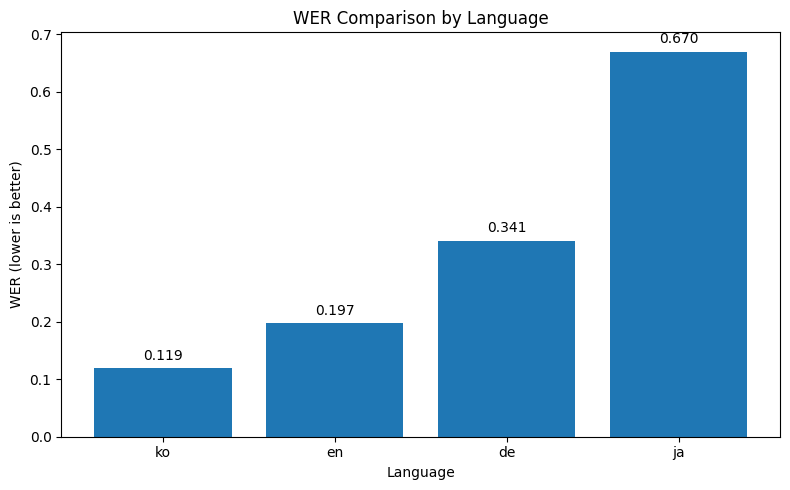

In [17]:
import matplotlib.pyplot as plt

# 최신 WER 결과 직접 할당
lang_wer_results = {
    'ko': 0.1191,
    'en': 0.1973,
    'de': 0.3411,
    'ja': 0.6700
}

# 시각화
langs = list(lang_wer_results.keys())
scores = [lang_wer_results[lang] for lang in langs]

plt.figure(figsize=(8, 5))
bars = plt.bar(langs, scores)
plt.title("WER Comparison by Language")
plt.xlabel("Language")
plt.ylabel("WER (lower is better)")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f"{yval:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("wer_comparison_chart_final.png")
plt.show()